# Risk Assessment for Loan Investment

This notebook contains the code for analysing the LendingClub data to build a model for risk assessment for loan investment for an investor



## Setup Environment

The following cells link the google drive and load the data-set. For the following code to work you need to have the 'accepted.csv' file in your google drive with the following directory structure: 

```
"My Drive/data/accepted.csv"
```

If you need to run the notebook without the grid search, set the "enable_grid_search" variable to False.


In [ ]:
from  google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Your code here
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

In [ ]:
enable_grid_search = False

The following cell is for the Spark environment setup on colab.

In [ ]:
# import statements
from pyspark.sql.functions import lower, col, when, count
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

import matplotlib
# Force matplotlib to not use any Xwindows backend.
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats

#spark = SparkSession.builder.getOrCreate()
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [1]:
data_path = "/content/drive/My Drive/data/accepted.csv"
data_df = spark.read.format("csv").option("header", "true").load(data_path)
data_df_1=data_df


NameError: ignored

In [ ]:
print((data_df.count(), len(data_df.columns)))

data_df.show(5)

(1048575, 151)
+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+-------+-----------+----------+--------------------+----+------------------+------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+---------

In [ ]:
data_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: string (nullable = true)
 |-- funded_amnt: string (nullable = true)
 |-- funded_amnt_inv: string (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

## Data Pre-processing

In the following cells we have inspected the data. Estimated the columns and rows with null values and have applied appropriate strategies to deal with these null values.

We see that the given dataset contains 151 columns and 1048575 rows. We have reomved the columns with more than 30% null values, because using these coloumns would lead to a significant loss in the number of records we could use for our analysis. 


After this inital cleaning of null-value columns we have 93 columns left. We further removed some solumns like url, zipcode, emp_title which were descriptive in nature and didn't have any relavance toward the prediction.


In [ ]:
#check null values
data_df.select([count(when(col(c).isNull(), c)).alias(c) for c in 
           data_df.columns]).show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-------+-----------+----------+---+-------+-------+-----+--------+----------+---+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+----

In [ ]:
import pyspark.sql.functions as F

threshold=data_df.count()*0.3

def drop_null_columns(df):
    """
    This function drops all columns which contain null values.
    """
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v > threshold]
    df = df.drop(*to_drop)
    return df

In [ ]:
#drop columns with more than 30% null data
data_df = drop_null_columns(data_df)

print((data_df.count(), len(data_df.columns)))

data_df.show(5)

(1048575, 93)
+--------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+-------+-----------+----------+--------------------+------------------+------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------------+--------------------+-------------------+--------------------------+-----------+----------------+--------------+------------+-----------+----------------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------

In [ ]:
#Drop columns that are irrelevant
data_df = data_df.drop('url','zip_code','id','emp_title')

print((data_df.count(), len(data_df.columns)))

data_df.show(5)

(1048575, 89)
+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-------+-----------+----------+------------------+------------------+----------+-----+-----------+----------------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------------+--------------------+-------------------+--------------------------+-----------+----------------+--------------+------------+-----------+----------------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+

Next we have checked the distribution of some of the important variables like loan_amount, funded_amount, loan_status, payment_plan, etc.

In [ ]:
#check if loan_amnt and funded_amnt have same values
data_df.where(data_df.loan_amnt!=data_df.funded_amnt).count()

3

In [ ]:
#check if funded_amnt and funded_amnt_inv have same values
data_df.where(data_df.funded_amnt!=data_df.funded_amnt_inv).count()

54520

In [ ]:
data_df.groupby('loan_status').count().show()

+------------------+------+
|       loan_status| count|
+------------------+------+
|        Fully Paid|482595|
|           Default|    21|
|            Oct-15|     1|
|              null|    12|
|   In Grace Period|  4227|
|       Charged Off|129186|
|Late (31-120 days)| 10879|
|           Current|419550|
| Late (16-30 days)|  2104|
+------------------+------+



In [ ]:
#remove loan_status null records
data_df = data_df.filter(data_df.loan_status.isNotNull())

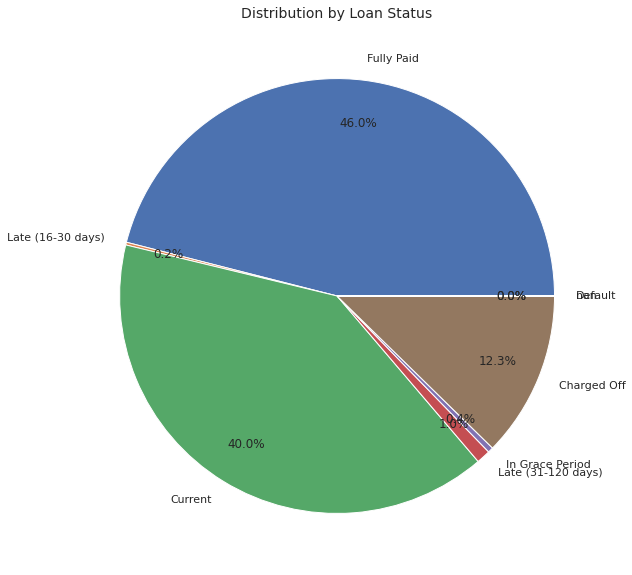

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

temp_data = data_df.groupby('loan_status').count().toPandas()
temp_data['loan_status'] = pd.Categorical(temp_data['loan_status'], ["Fully Paid", "Late (16-30 days)", "Current","Late (31-120 days)","In Grace Period","Charged Off","Default"])
temp_data = temp_data.sort_values('loan_status')

labels = temp_data['loan_status']
pie, ax = plt.subplots(figsize=[15,10])
plt.pie(x=temp_data['count'], autopct="%.1f%%", labels=labels, pctdistance=0.8)
plt.title("Distribution by Loan Status", fontsize=14);
pie.savefig("LoanStatusPieChart.png")

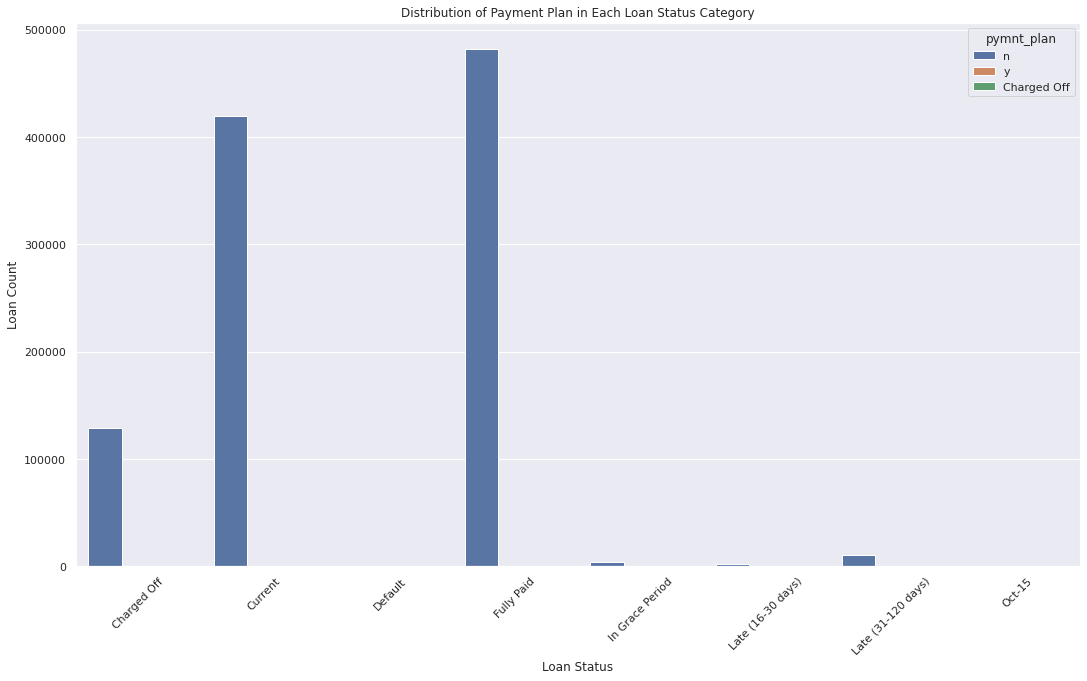

In [ ]:
fig, ax =plt.subplots(1,1,figsize=(18,10))

temp_data = data_df.groupby('loan_status','pymnt_plan').count().sort('loan_status').toPandas()

s0 = sns.barplot(x="loan_status", y="count", hue="pymnt_plan", data=temp_data)
s0.set(xlabel='Loan Status',ylabel='Loan Count', title='Distribution of Payment Plan in Each Loan Status Category')
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

fig.savefig("LoanStatus_PaymentPlan_BarPlot.pdf")

In [ ]:
data_df.groupby('policy_code').count().show()

+-----------+-------+
|policy_code|  count|
+-----------+-------+
|       null|      1|
|        500|      1|
|          1|1048561|
+-----------+-------+



In [ ]:
#Drop columns that are redundant, irrelevant and non-useful data
data_df = data_df.drop('title','funded_amnt','pymnt_plan','policy_code')

print((data_df.count(), len(data_df.columns)))

data_df.show(5)

(1048563, 85)
+---------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-------+-----------+------------------+----------+-----+-----------+----------------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------------+--------------------+-------------------+--------------------------+----------------+--------------+------------+-----------+----------------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+--------

In [ ]:
data_df.groupby('acc_now_delinq').count().show()

+--------------+-------+
|acc_now_delinq|  count|
+--------------+-------+
|             7|      1|
|             3|     25|
|             0|1043911|
|          null|      2|
|             5|      1|
|             6|      1|
|             1|   4393|
|             4|      5|
|            14|      1|
|             2|    223|
+--------------+-------+



### Dropping irrelevant attributes

Next we have meticulously analyzed what all the other variables mean by refering to the Data Dictionary for this data and doing some research on our own. After careful consideration we have dropped the ones which we felt weren't relevant in predicting whether a loan will get default or not.

In [ ]:
#Drop columns that are irrelevant - current loan values
data_df = data_df.drop('out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee', \
                       'last_pymnt_d', 'last_pymnt_d','last_pymnt_amnt','last_credit_pull_d','last_fico_range_high','last_fico_range_low','collections_12_mths_ex_med','tot_coll_amt', \
                       'issue_d','acc_now_delinq','delinq_amnt')

In [ ]:
data_df = data_df.drop('mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','acc_now_delinq','tot_coll_amt','mths_since_recent_bc','mths_since_recent_inq')
data_df = data_df.drop('num_accts_ever_120_pd','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m',\
                       'num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m')
data_df = data_df.drop('hardship_flag','disbursement_method','debt_settlement_flag','bc_open_to_buy','percent_bc_gt_75','pct_tl_nvr_dlq')

print((data_df.count(), len(data_df.columns)))

data_df.show(5)

(1048563, 43)
+---------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-----------+------------------+----------+-----+-----------+----------------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+----------------+-----------+----------------+--------------------+-----------+-------+------------------------+--------+--------------+---------------+--------------------+---------+---------------+-----------------+--------------+--------------------------+
|loan_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|           purpose|addr_state|  dti|delinq_2yrs|earliest_cr_line|fico_range_low|fico_range_high|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|out_prncp|application_type|tot_cur_bal|total_rev_hi_lim|acc_open_past_

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


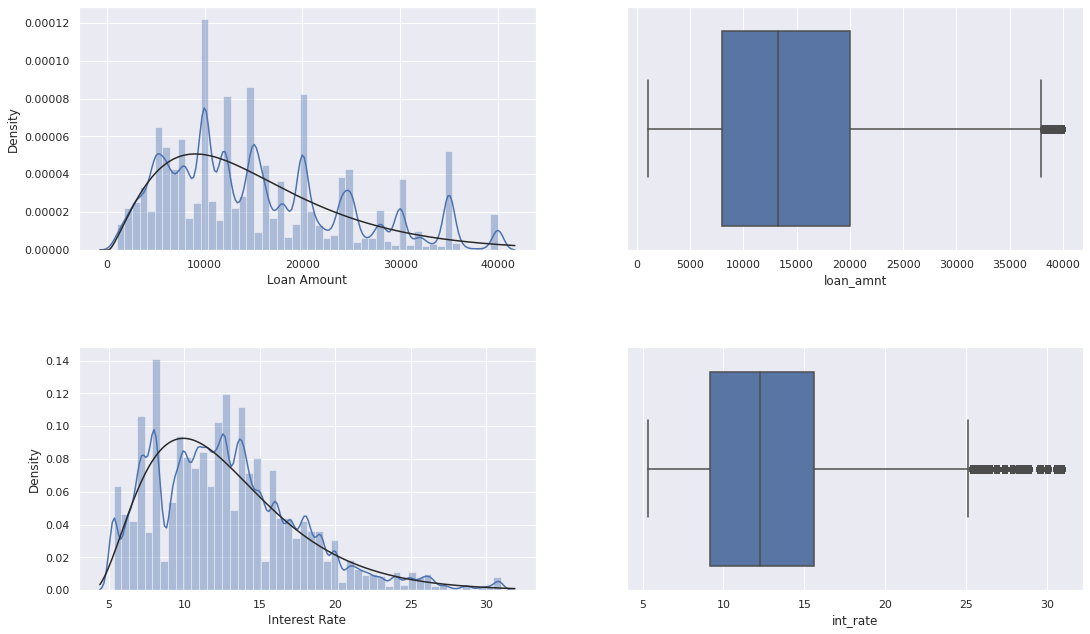

In [ ]:
from scipy import stats

tmp_df = data_df.select("loan_amnt", "int_rate")
tmp_df = tmp_df.withColumn("loan_amnt",data_df["loan_amnt"].cast('float'))
tmp_df = tmp_df.withColumn("int_rate",data_df["int_rate"].cast('float'))
tmp_df_pd=tmp_df.toPandas()
#loanDF.printSchema()

fig, ax =plt.subplots(2,2, figsize=(18,12))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

# Loan amount distribution plots
sns.distplot(tmp_df_pd.loan_amnt, fit=stats.gamma, axlabel="Loan Amount", label="Loan Amount Frequency distribution", ax=ax[0][0])
sns.boxplot(x= tmp_df_pd.loan_amnt, ax=ax[0][1])

# Interest rates distribution plots
sns.distplot(tmp_df_pd.int_rate, fit=stats.gamma, axlabel="Interest Rate", label="Interest Frequency distribution", ax=ax[1][0])
sns.boxplot(x=tmp_df_pd.int_rate, ax=ax[1][1])

fig.show()

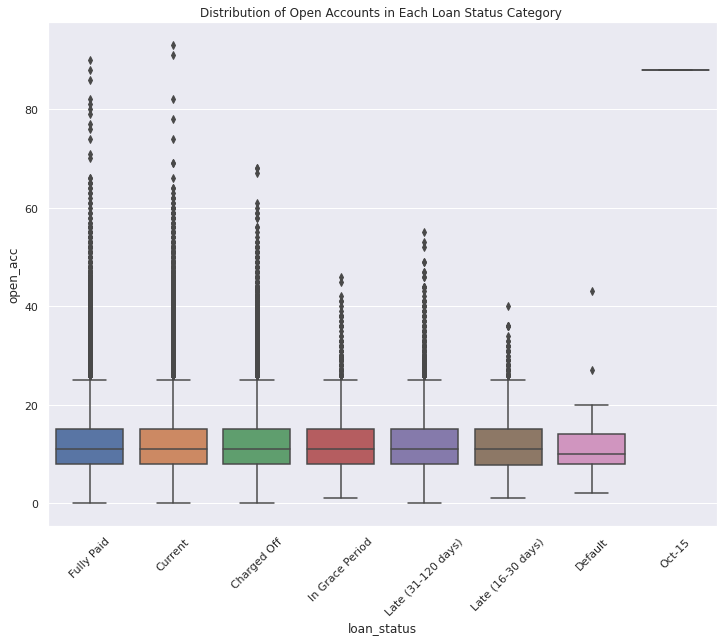

In [ ]:
tmp_df = data_df.select("loan_status", "open_acc", "loan_amnt")
tmp_df = tmp_df.withColumn("open_acc",data_df["open_acc"].cast('float'))
tmp_df_pd=tmp_df.toPandas()

fig, ax =plt.subplots(1,1,figsize=(12,8))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s1 = sns.boxplot(x="loan_status", y="open_acc", data=tmp_df_pd)
s1.set_xticklabels(s1.get_xticklabels(),rotation=45)
s1.set_title('Distribution of Open Accounts in Each Loan Status Category ')

plt.show()

fig.savefig("LoanStatus_OpenAcc_BoxPlot.pdf")

In [ ]:
data_df_temp = data_df.withColumn("annual_inc_range", when((col("annual_inc") >= -10000) & (col("annual_inc") < 20000), "0-20000")
                           .when((col("annual_inc") >= 20000) & (col("annual_inc") < 40000), "20000-40000")
                          .when((col("annual_inc") >= 40000) & (col("annual_inc") < 60000), "40000-60000")
                          .when((col("annual_inc") >= 60000) & (col("annual_inc") < 80000), "60000-80000")
                          .when((col("annual_inc") >= 80000) & (col("annual_inc") < 100000), "80000-100000")
                          .when((col("annual_inc") >= 100000) & (col("annual_inc") < 120000), "100000-120000")
                          .when((col("annual_inc") >= 120000) & (col("annual_inc") < 140000), "120000-140000")
                          .when((col("annual_inc") >= 140000) & (col("annual_inc") < 160000), "140000-160000")
                          .when((col("annual_inc") >= 160000) & (col("annual_inc") < 180000), "160000-180000")
                          .when((col("annual_inc") >= 180000) & (col("annual_inc") < 200000), "180000-200000")
                          .when((col("annual_inc") >= 200000) & (col("annual_inc") < 250000), "200000-250000")
                          .when((col("annual_inc") >= 250000) & (col("annual_inc") < 500000), "250000-500000")
                          .when((col("annual_inc") >= 500000) & (col("annual_inc") < 1000000), "500000-1000000")
                          .when((col("annual_inc") >= 1000000) & (col("annual_inc") < 5000000), "1000000-5000000")
                          .otherwise(">5000000"))

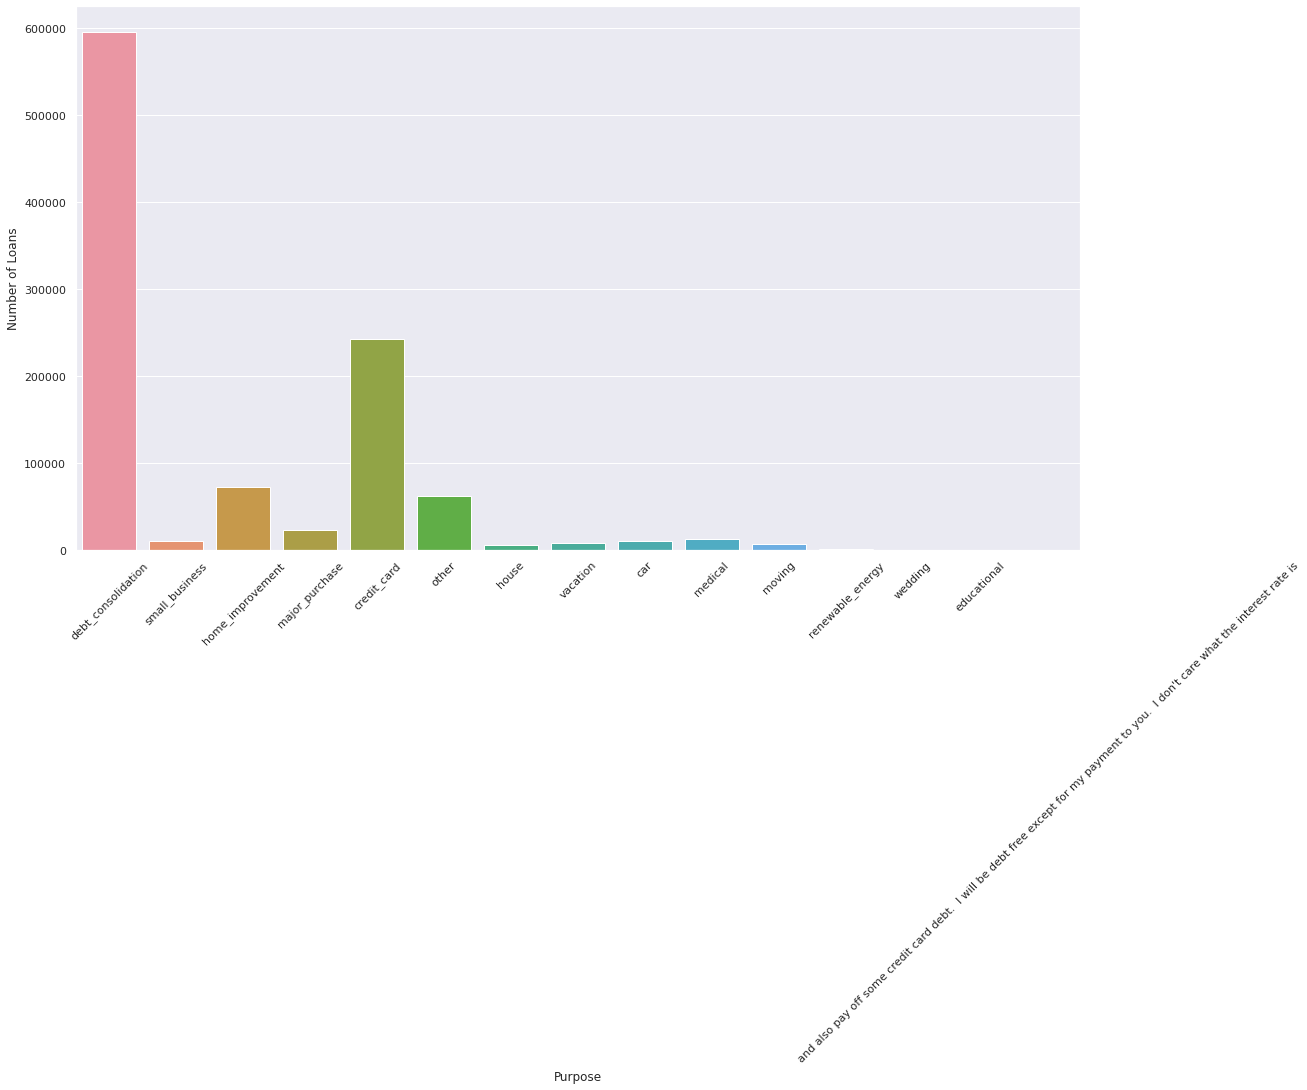

In [ ]:
fig, ax =plt.subplots(1,1,figsize=(18,10))

tmpLoanDF = data_df_temp.select("purpose", "int_rate", "loan_amnt",).toPandas()

s0 = sns.countplot(x="purpose",data=tmpLoanDF)
s0.set(xlabel='Purpose',ylabel='Number of Loans')
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

fig.savefig("LoanByPurpose.pdf")

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


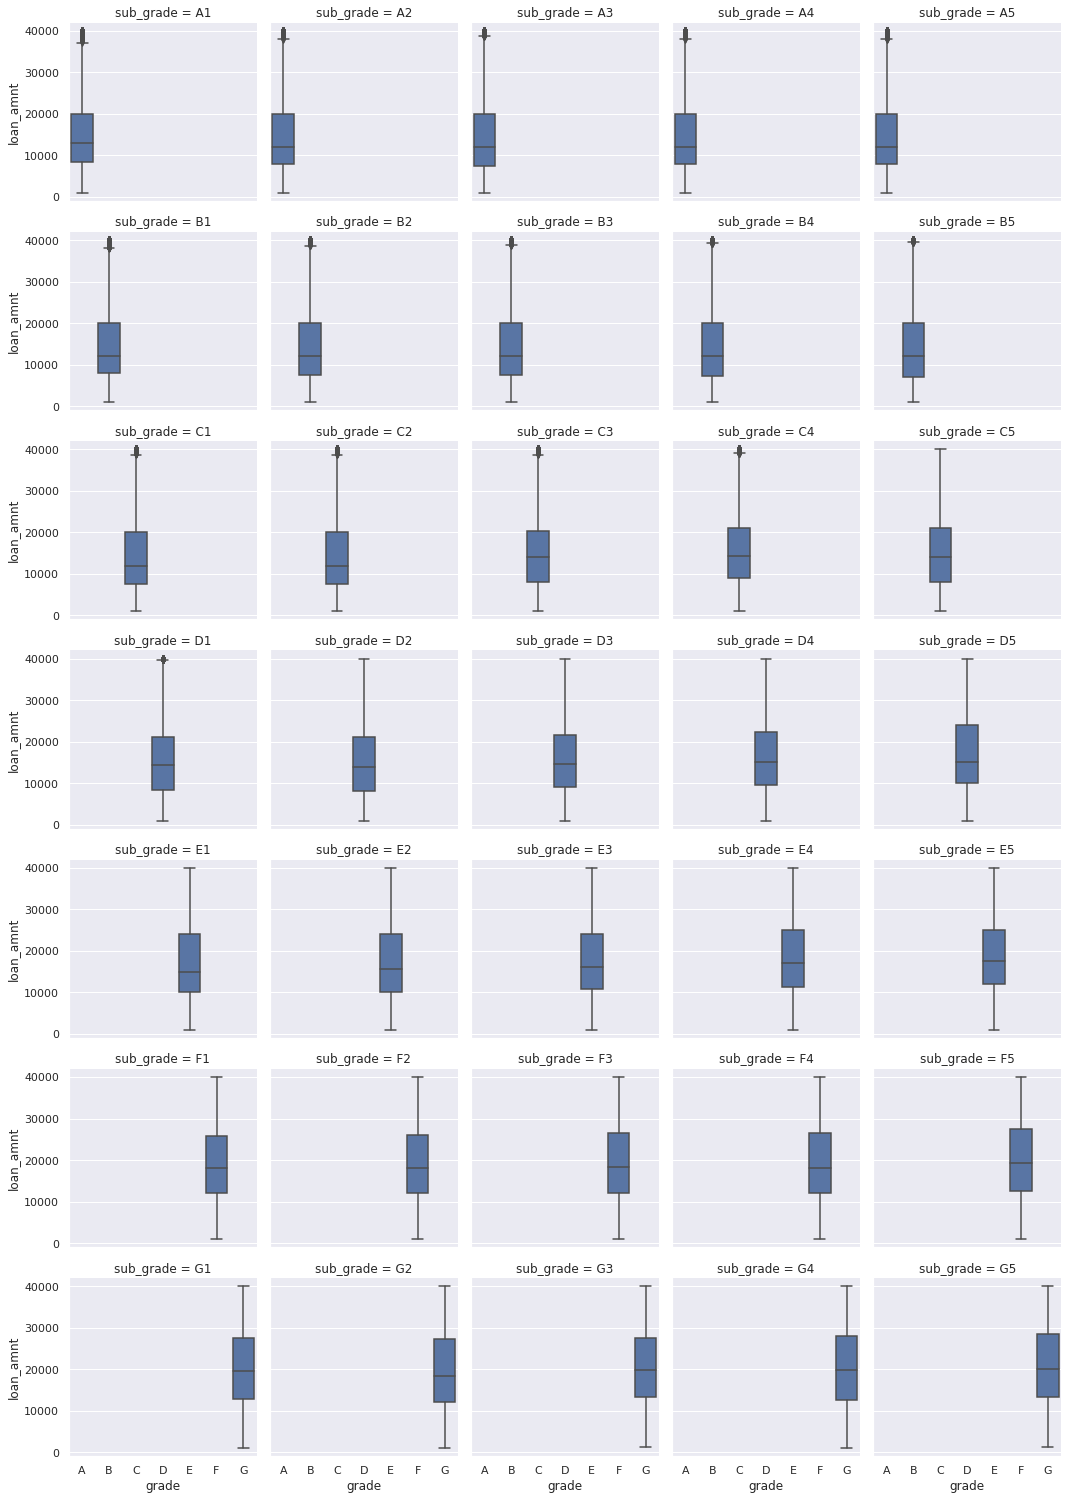

In [ ]:
tmpDF = data_df.select("sub_grade", "grade", "loan_amnt", "int_rate").toPandas()
tmpDF['grade'] = tmpDF['grade'].astype('category')
tmpDF['sub_grade'] = tmpDF['sub_grade'].astype('category')
tmpDF['loan_amnt'] = tmpDF['loan_amnt'].astype('float')

g = sns.FacetGrid(tmpDF, col="sub_grade", sharex=True, col_wrap=5)
#g = sns.FacetGrid(loanDF.toPandas(), col="sub_grade", sharex=False, col_wrap=5)
g.map(sns.boxplot, 'grade', 'loan_amnt')

g.savefig("FacetGrid_LoanAmt.pdf")

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


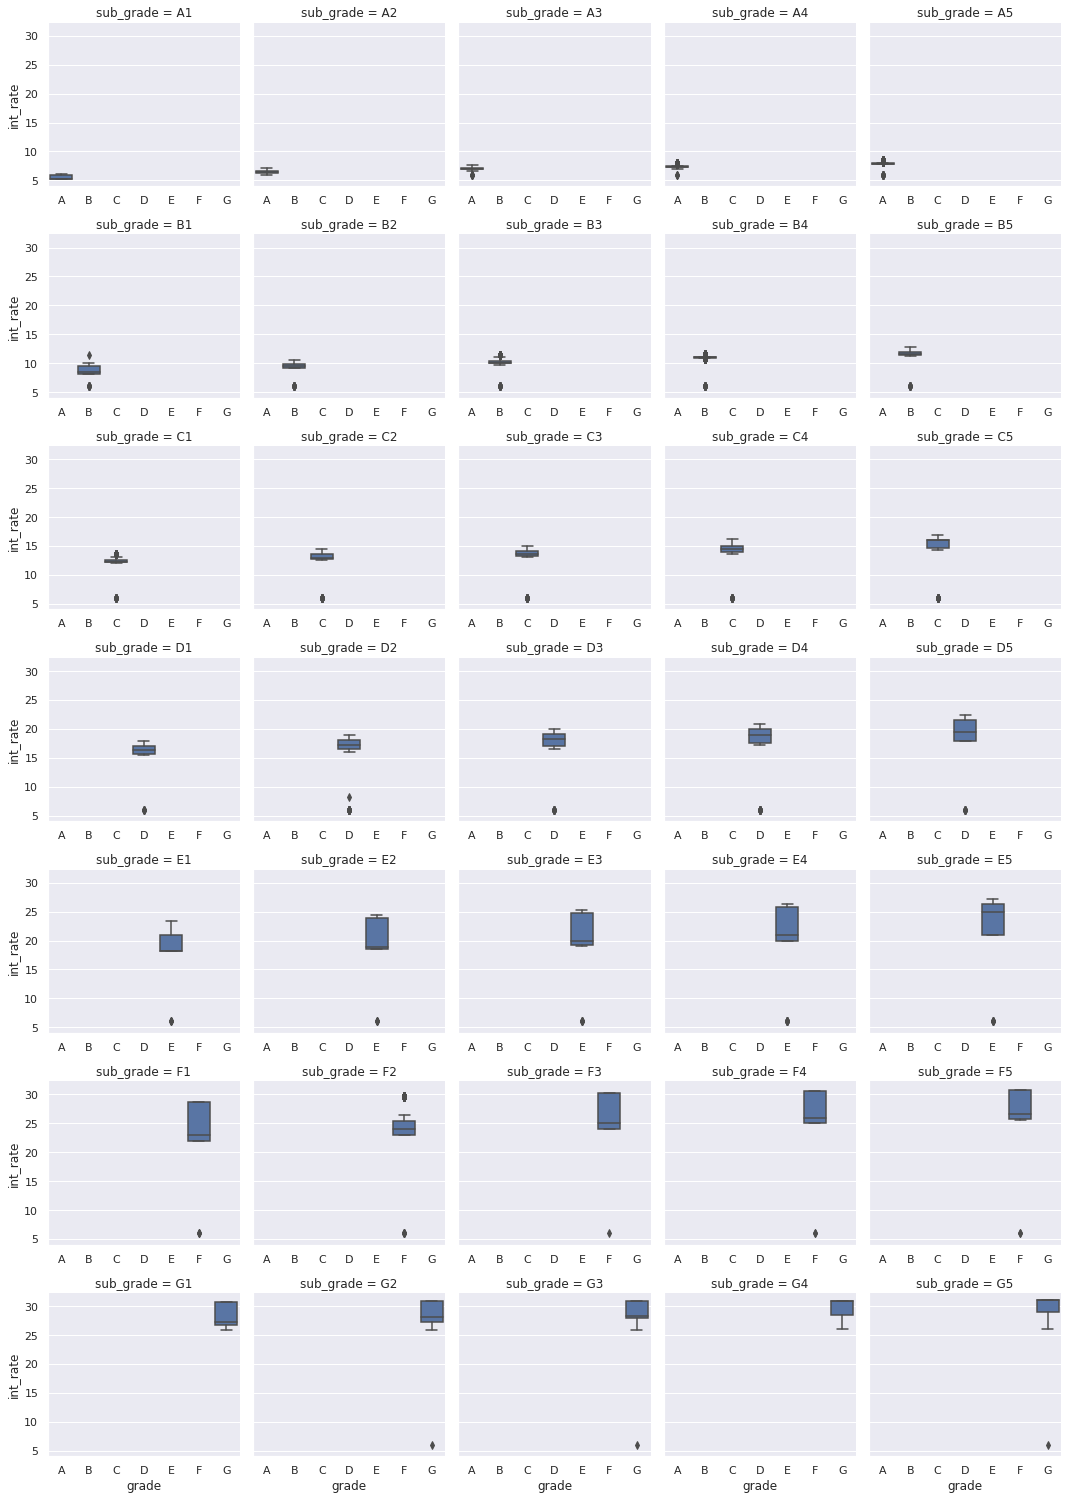

In [ ]:
# g = sns.FacetGrid(tmpDF, col="sub_grade", sharex=False, col_wrap=5)

# g.map(sns.boxplot, 'grade', 'int_rate')

# g.savefig("FacetGrid_LoanInt.pdf")



tmpDF['int_rate'] = tmpDF['int_rate'].astype('float')
g = sns.FacetGrid(tmpDF, col="sub_grade", sharex=False, col_wrap=5)
g.map(sns.boxplot, 'grade', 'int_rate')

g.savefig("FacetGrid_LoanInt.pdf")

In [ ]:
from pyspark.sql.functions import split
from pyspark.sql.types import IntegerType

data_df = data_df.withColumn("term", split(col("term"),"\s").getItem(1))
data_df = data_df.withColumn("term",data_df["term"].cast(IntegerType()))

data_df.groupby('term').count().show()

+----+------+
|term| count|
+----+------+
|  60|312603|
|  36|735960|
+----+------+



In [ ]:
data_df = data_df.withColumn("emp_length", split(col("emp_length"),"\s+").getItem(0))
data_df = data_df.withColumn('emp_length', when(col('emp_length')=='<', 0).otherwise(col('emp_length')))
data_df = data_df.withColumn("emp_length", split(col("emp_length"),"\+").getItem(0))
data_df = data_df.withColumn("emp_length",data_df["emp_length"].cast(IntegerType()))

data_df.groupby('emp_length').count().show()

+----------+------+
|emp_length| count|
+----------+------+
|      null| 69949|
|         1| 69015|
|         6| 43801|
|         3| 84262|
|         5| 63365|
|         9| 37551|
|         4| 63285|
|         8| 43262|
|         7| 40767|
|        10|349581|
|         2| 94921|
|         0| 88804|
+----------+------+



In [ ]:
data_df = data_df.withColumn('emp_status', when(col('emp_length').isNull(), 0).otherwise(1))
data_df = data_df.withColumn('emp_length', when(col('emp_length').isNull(), 0).otherwise(col('emp_length')))
data_df.groupby('emp_length','emp_status').count().show()

+----------+----------+------+
|emp_length|emp_status| count|
+----------+----------+------+
|         6|         1| 43801|
|         3|         1| 84262|
|         7|         1| 40767|
|         9|         1| 37551|
|         1|         1| 69015|
|         0|         0| 69949|
|        10|         1|349581|
|         8|         1| 43262|
|         2|         1| 94921|
|         0|         1| 88804|
|         5|         1| 63365|
|         4|         1| 63285|
+----------+----------+------+



In [ ]:
data_df.select([count(when(col(c).isNull(), c)).alias(c) for c in 
           data_df.columns]).show()

           

+---------+---------------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-----------+-------+----------+---+-----------+----------------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+----------------+-----------+----------------+--------------------+-----------+-------+------------------------+--------+--------------+---------------+--------------------+---------+---------------+-----------------+--------------+--------------------------+----------+
|loan_amnt|funded_amnt_inv|term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|purpose|addr_state|dti|delinq_2yrs|earliest_cr_line|fico_range_low|fico_range_high|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|out_prncp|application_type|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|bc_util|chargeoff_with

In [ ]:
from pyspark.sql.functions import avg
# Inputing mean value for "revol_util"
rev_util_mean = float(data_df.select(avg("revol_util")).take(1)[0][0])

data_df = data_df.withColumn("revol_util", when(col("revol_util").isNull(), rev_util_mean).otherwise(col("revol_util")))

In [ ]:
from pyspark.sql.functions import avg
# Inputing mean value for "revol_util"
bc_util_mean = float(data_df.select(avg("bc_util")).take(1)[0][0])

data_df = data_df.withColumn("bc_util", when(col("bc_util").isNull(), bc_util_mean).otherwise(col("bc_util")))

In [ ]:
from pyspark.sql.functions import avg
# Inputing mean value for "revol_util"
dti_mean = float(data_df.select(avg("dti")).take(1)[0][0])

data_df = data_df.withColumn("dti", when(col("dti").isNull(), dti_mean).otherwise(col("dti")))

In [ ]:
data_df = data_df.dropna(how="any") 

print((data_df.count(), len(data_df.columns)))

(1048532, 44)


In [ ]:
data_df.select([count(when(col(c).isNull(), c)).alias(c) for c in 
           data_df.columns]).show()


#for MAaz:
data_df_3=data_df

+---------+---------------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-----------+-------+----------+---+-----------+----------------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+----------------+-----------+----------------+--------------------+-----------+-------+------------------------+--------+--------------+---------------+--------------------+---------+---------------+-----------------+--------------+--------------------------+----------+
|loan_amnt|funded_amnt_inv|term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|purpose|addr_state|dti|delinq_2yrs|earliest_cr_line|fico_range_low|fico_range_high|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|out_prncp|application_type|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|bc_util|chargeoff_with

The current data has 5 different categories for loan_status. So we have changed it to only two categories and combined a few of the categories as Default.

In [ ]:
data_df = data_df.filter(~col('loan_status').isin(['Oct-15','In Grace Period','Current']))

print((data_df.count(), len(data_df.columns)))

data_df.groupby('loan_status').count().show()

(624778, 44)
+------------------+------+
|       loan_status| count|
+------------------+------+
|        Fully Paid|482592|
|           Default|    21|
|       Charged Off|129183|
|Late (31-120 days)| 10878|
| Late (16-30 days)|  2104|
+------------------+------+



In [ ]:
data_df = data_df.withColumn('isDefault', when(col('loan_status').isin('Default','Charged Off','Late (31-120 days)','Late (16-30 days)'),1).otherwise(0))

data_df.groupby(['loan_status','isDefault']).count().show()

+------------------+---------+------+
|       loan_status|isDefault| count|
+------------------+---------+------+
| Late (16-30 days)|        1|  2104|
|           Default|        1|    21|
|Late (31-120 days)|        1| 10878|
|        Fully Paid|        0|482592|
|       Charged Off|        1|129183|
+------------------+---------+------+



In [ ]:
data_df.printSchema()

root
 |-- loan_amnt: string (nullable = true)
 |-- funded_amnt_inv: string (nullable = true)
 |-- term: integer (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: integer (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- fico_range_low: string (nullable = true)
 |-- fico_range_high: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- revol_util: s

### Converting Categorical Variables

We have analyzed some of the categorical variables and converted it into numerical values by one-hot encoding or label encoding whichever is applicable.

In [ ]:
data_df_new = data_df.withColumn('term_code', when(col('term')==36, 0).otherwise(1))
data_df_new.groupby('term','term_code').count().show()

+----+---------+------+
|term|term_code| count|
+----+---------+------+
|  60|        1|151076|
|  36|        0|473702|
+----+---------+------+



In [ ]:
data_df_new = data_df_new.withColumn('home_ownership_code', when(col('home_ownership')=='ANY', 4).when(col('home_ownership')=='OWN', 3).when(col('home_ownership')=='RENT', 2).when(col('home_ownership')=='MORTGAGE', 1).otherwise(0))
data_df_new = data_df_new.withColumn("home_ownership_code",data_df_new["home_ownership_code"].cast(IntegerType()))
data_df_new.groupby('home_ownership','home_ownership_code').count().show()

+--------------+-------------------+------+
|home_ownership|home_ownership_code| count|
+--------------+-------------------+------+
|          RENT|                  2|249014|
|          NONE|                  0|     2|
|           ANY|                  4|    22|
|      MORTGAGE|                  1|304264|
|           OWN|                  3| 71476|
+--------------+-------------------+------+



In [ ]:
data_df_new = data_df_new.withColumn('grade_code', when(col('grade')=='A', 6).when(col('grade')=='B', 5).when(col('grade')=='C', 4).when(col('grade')=='D', 3).when(col('grade')=='E', 2).when(col('grade')=='F', 1).otherwise(0))
data_df_new = data_df_new.withColumn("grade_code",data_df_new["grade_code"].cast(IntegerType()))
data_df_new.groupby('grade','grade_code').count().show()

+-----+----------+------+
|grade|grade_code| count|
+-----+----------+------+
|    G|         0|  4522|
|    B|         5|176034|
|    E|         2| 44210|
|    F|         1| 13854|
|    D|         3| 88822|
|    A|         6|117889|
|    C|         4|179447|
+-----+----------+------+



In [ ]:
data_df_new = data_df_new.withColumn('sub_grade_code', \
                                 when(col('sub_grade')=='G5', 0).when(col('sub_grade')=='G4', 1).when(col('sub_grade')=='G3', 2).when(col('sub_grade')=='G2', 3).when(col('grade')=='G1', 4) \
                                .when(col('sub_grade')=='F5', 5).when(col('sub_grade')=='F4', 6).when(col('sub_grade')=='F3', 7).when(col('sub_grade')=='F2', 8).when(col('grade')=='F1', 9) \
                                .when(col('sub_grade')=='E5', 10).when(col('sub_grade')=='E4', 11).when(col('sub_grade')=='E3', 12).when(col('sub_grade')=='E2', 13).when(col('grade')=='E1', 14) \
                                .when(col('sub_grade')=='D5', 15).when(col('sub_grade')=='D4', 16).when(col('sub_grade')=='D3', 17).when(col('sub_grade')=='D2', 18).when(col('grade')=='D1', 19) \
                                .when(col('sub_grade')=='C5', 20).when(col('sub_grade')=='C4', 21).when(col('sub_grade')=='C3', 22).when(col('sub_grade')=='C2', 23).when(col('grade')=='C1', 24) \
                                .when(col('sub_grade')=='B5', 25).when(col('sub_grade')=='B4', 26).when(col('sub_grade')=='B3', 27).when(col('sub_grade')=='B2', 28).when(col('grade')=='B1', 29) \
                                .when(col('sub_grade')=='A5', 30).when(col('sub_grade')=='A4', 31).when(col('sub_grade')=='A3', 32).when(col('sub_grade')=='A2', 33).otherwise(34))
data_df_new = data_df_new.withColumn("sub_grade_code",data_df_new["sub_grade_code"].cast(IntegerType()))
data_df_new.groupby('sub_grade','sub_grade_code').count().show()

+---------+--------------+-----+
|sub_grade|sub_grade_code|count|
+---------+--------------+-----+
|       E4|            11| 7297|
|       C2|            23|37259|
|       G5|             0|  648|
|       C3|            22|35458|
|       A2|            33|18803|
|       A5|            30|31892|
|       A4|            31|24779|
|       E2|            13|10210|
|       A3|            32|17802|
|       D2|            18|19068|
|       B5|            25|37630|
|       C1|            34|39693|
|       D1|            34|22827|
|       D3|            17|17430|
|       F1|            34| 4291|
|       B2|            28|33207|
|       G4|             1|  709|
|       F2|             8| 3144|
|       F4|             6| 2069|
|       D5|            15|13895|
+---------+--------------+-----+
only showing top 20 rows



In [ ]:
data_df_new = data_df_new.withColumn('ver_status_code', when(col('verification_status')=='Source Verified', 2).when(col('verification_status')=='Verified', 1).otherwise(0))
data_df_new = data_df_new.withColumn("ver_status_code",data_df_new["ver_status_code"].cast(IntegerType()))
data_df_new.groupby('verification_status','ver_status_code').count().show()

+-------------------+---------------+------+
|verification_status|ver_status_code| count|
+-------------------+---------------+------+
|    Source Verified|              2|267286|
|           Verified|              1|176176|
|       Not Verified|              0|181316|
+-------------------+---------------+------+



In [ ]:
categories = data_df_new.select("purpose").distinct().toPandas().purpose.tolist()

exprs = [F.when(F.col("purpose") == category, 1).otherwise(0).alias(category)
         for category in categories]

data_df_new = data_df_new.select("*", *exprs)

newCategories = []
for category in categories:
    data_df_new = data_df_new.withColumnRenamed(category, "purpose_"+category)
    newCategories.append("purpose_"+category)
print(newCategories)

['purpose_wedding', 'purpose_educational', 'purpose_other', 'purpose_small_business', 'purpose_debt_consolidation', 'purpose_credit_card', 'purpose_moving', 'purpose_vacation', 'purpose_renewable_energy', 'purpose_house', 'purpose_car', 'purpose_major_purchase', 'purpose_medical', 'purpose_home_improvement']


In [ ]:
data_df_new = data_df_new.withColumn('in_lst_code', when(col('initial_list_status')=='f', 0).otherwise(1))
data_df_new = data_df_new.withColumn("in_lst_code",data_df_new["in_lst_code"].cast(IntegerType()))
data_df_new.groupby('initial_list_status','in_lst_code').count().show()

+-------------------+-----------+------+
|initial_list_status|in_lst_code| count|
+-------------------+-----------+------+
|                  f|          0|196399|
|                  w|          1|428379|
+-------------------+-----------+------+



In [ ]:
data_df_new = data_df_new.withColumn('app_type_code', when(col('application_type')=='Joint App', 1).otherwise(0))
data_df_new = data_df_new.withColumn("app_type_code",data_df_new["app_type_code"].cast(IntegerType()))
data_df_new.groupby('application_type','app_type_code').count().show()

+----------------+-------------+------+
|application_type|app_type_code| count|
+----------------+-------------+------+
|      Individual|            0|610058|
|       Joint App|            1| 14720|
+----------------+-------------+------+



In [ ]:
data_df_new = data_df_new.drop('home_ownership','verification_status','grade','sub_grade','term','initial_list_status','application_type','loan_status')

print((data_df_new.count(), len(data_df_new.columns)))

data_df_new.show(5)

(624778, 58)
+---------+---------------+--------+-----------+----------+----------+------------------+----------+-----+-----------+----------------+--------------+---------------+--------------+--------+-------+---------+----------+---------+---------+-----------+----------------+--------------------+-----------+-------+------------------------+--------+--------------+---------------+--------------------+---------+---------------+-----------------+--------------+--------------------------+----------+---------+---------+-------------------+----------+--------------+---------------+---------------+-------------------+-------------+----------------------+--------------------------+-------------------+--------------+----------------+------------------------+-------------+-----------+----------------------+---------------+------------------------+-----------+-------------+
|loan_amnt|funded_amnt_inv|int_rate|installment|emp_length|annual_inc|           purpose|addr_state|  dti|delinq_2yrs|e

In [ ]:
tointeger_columns = ['emp_length','delinq_2yrs','fico_range_low','fico_range_high','inq_last_6mths','open_acc','pub_rec', 'total_acc',\
                     'acc_open_past_24mths','chargeoff_within_12_mths','mort_acc','num_actv_bc_tl','num_actv_rev_tl', \
                     'pub_rec_bankruptcies','tax_liens','isDefault']

tofloat_columns = ['loan_amnt','funded_amnt_inv','int_rate','installment','annual_inc','dti','revol_bal','revol_util','tot_cur_bal',\
                   'total_rev_hi_lim','avg_cur_bal','bc_util','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit', \
                   'total_il_high_credit_limit']

In [ ]:
#cast required columns to integer 
for c in tointeger_columns:
  data_df_new = data_df_new.withColumn(c,col(c).cast(IntegerType()))

In [ ]:
#convert required columns to float 
for c in tofloat_columns:
  data_df_new = data_df_new.withColumn(c,col(c).cast('float'))

In [ ]:
data_df_new.printSchema()

root
 |-- loan_amnt: float (nullable = true)
 |-- funded_amnt_inv: float (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: float (nullable = true)
 |-- emp_length: integer (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- fico_range_low: integer (nullable = true)
 |-- fico_range_high: integer (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- pub_rec: integer (nullable = true)
 |-- revol_bal: float (nullable = true)
 |-- revol_util: float (nullable = true)
 |-- total_acc: integer (nullable = true)
 |-- out_prncp: string (nullable = true)
 |-- tot_cur_bal: float (nullable = true)
 |-- total_rev_hi_lim: float (nullable = true)
 |-- acc_open_past_24mths: integer (nullable = true)
 |-- avg

In [ ]:
## gather numerical features
numerical_features = [t[0] for t in data_df_new.dtypes if t[1] == 'int' or t[1]=='float']
df_numeric = data_df_new.select(numerical_features).describe().toPandas().transpose()
df_numeric

,0,1,2,3,4
summary,count,mean,stddev,min,max
loan_amnt,624778,14614.214168872784,8834.973060468541,1000.0,40000.0
funded_amnt_inv,624778,14608.18805277447,8832.126470595773,775.0,40000.0
int_rate,624778,12.77696431767162,4.821636286121929,5.31,30.99
installment,624778,440.65869185740513,263.97334243377566,14.01,1719.83
emp_length,624778,5.5656233093994985,3.885100545974842,0,10
annual_inc,624778,76877.66959354626,74907.53769762971,0.0,1.09992E7
dti,624778,18.984122286614472,12.077907344215623,-1.0,999.0
delinq_2yrs,624778,0.33946777895508484,0.9230935974428195,0,39
fico_range_low,624778,695.4639087803988,31.8829728983321,660,845


In [ ]:
correlation_df_new = data_df_new.select(numerical_features).toPandas().corr()
correlation_df_new

,loan_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_util,chargeoff_within_12_mths,mort_acc,num_actv_bc_tl,num_actv_rev_tl,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,emp_status,isDefault,term_code,home_ownership_code,grade_code,sub_grade_code,ver_status_code,purpose_wedding,purpose_educational,purpose_other,purpose_small_business,purpose_debt_consolidation,purpose_credit_card,purpose_moving,purpose_vacation,purpose_renewable_energy,purpose_house,purpose_car,purpose_major_purchase,purpose_medical,purpose_home_improvement,in_lst_code,app_type_code
loan_amnt,1.000000,0.999994,0.125820,0.952230,0.105078,0.300168,0.020288,-0.008405,0.113468,0.113467,-0.024804,0.181127,-0.068998,0.315467,0.109174,0.202115,0.315257,0.327880,0.008512,0.230388,0.053340,-0.005070,0.224026,0.201720,0.155693,-0.096145,0.005461,0.336486,0.276139,0.376508,0.202803,0.089452,0.072287,0.376177,-0.133250,-0.124288,-0.098275,0.097443,-0.002485,-0.001778,-0.125416,0.014242,0.096611,0.029337,-0.061983,-0.081132,-0.013190,0.006400,-0.058544,-0.035365,-0.067761,-0.008044,0.063940,0.080072
funded_amnt_inv,0.999994,1.000000,0.125654,0.952172,0.105112,0.300214,0.020181,-0.008440,0.113652,0.113652,-0.024870,0.181098,-0.069003,0.315459,0.109075,0.202109,0.315299,0.327929,0.008433,0.230436,0.053237,-0.005087,0.224066,0.201688,0.155632,-0.096135,0.005446,0.336538,0.276123,0.376588,0.202790,0.089489,0.072218,0.376228,-0.133269,-0.124077,-0.098164,0.097403,-0.002484,-0.001777,-0.125383,0.014243,0.096580,0.029352,-0.061967,-0.081139,-0.013183,0.006390,-0.058547,-0.035372,-0.067746,-0.008041,0.064687,0.080089
int_rate,0.125820,0.125654,1.000000,0.143916,-0.022479,-0.082519,0.161978,0.042276,-0.371737,-0.371734,0.217314,-0.006038,0.056210,-0.044056,0.193337,-0.046477,-0.081090,-0.167956,0.225982,-0.080857,0.210398,0.009930,-0.095442,0.004785,0.070513,0.066902,0.009730,-0.114714,0.010973,-0.231517,0.010706,-0.010236,0.293183,0.405673,0.055954,-0.959135,-0.731837,0.132285,0.003015,-0.000327,0.069015,0.065755,0.100727,-0.176838,0.037801,0.009123,0.013082,0.046308,-0.018708,-0.006767,0.019170,-0.020632,-0.148758,0.066015
installment,0.952230,0.952172,0.143916,1.000000,0.090593,0.289845,0.024387,0.000358,0.067052,0.067052,-0.000022,0.168546,-0.057039,0.302732,0.124100,0.176981,0.285884,0.301648,0.023046,0.206244,0.072105,-0.002731,0.191242,0.201180,0.160429,-0.088395,0.012950,0.304879,0.260515,0.343966,0.187815,0.079233,0.055505,0.134492,-0.108708,-0.133467,-0.108274,0.102851,-0.002305,-0.001764,-0.113508,0.026351,0.096244,0.018424,-0.057080,-0.077331,-0.011361,0.011955,-0.056954,-0.035459,-0.064622,-0.011425,0.005458,0.075756
emp_length,0.105078,0.105112,-0.022479,0.090593,1.000000,0.094959,-0.005834,0.025103,0.017331,0.017331,0.002234,0.064008,0.014257,0.087715,0.040961,0.104703,0.120042,0.086006,0.036249,0.097672,0.032556,0.008182,0.166214,0.076842,0.115257,0.003114,0.010021,0.131374,0.026451,0.067342,0.013757,0.373124,-0.034518,0.060696,-0.126115,0.019069,0.014686,-0.002173,0.000612,0.000793,-0.005709,-0.006651,0.025577,-0.029775,-0.030135,0.009116,0.001018,-0.007260,-0.012602,-0.015007,-0.005082,0.031484,0.018376,-0.067804
annual_inc,0.300168,0.300214,-0.082519,0.289845,0.094959,1.000000,-0.138958,0.035826,0.070627,0.070627,0.025202,0.126234,-0.004135,0.272472,0.036757,0.162315,0.378028,0.269707,0.052194,0.292360,-0.001632,0.006713,0.206407,0.108689,0.076780,-0.042831,0.037758,0.390650,0.297525,0.261816,0.247291,0.095331,-0.040466,0.045251,-0.108327,0.084209,0.062911,0.048991,-0.000340,-0.000209,-0.015534,0.023270,-0.023995,0.002130,-0.008767,-0.007367,-0.001636,0.005938,-0.005689,0.006304,-0.007835,0.054806,0.037681,-0.042907
dti,0.020288,0.020181,0.161978,0.024387,-0.005834,-0.138958,1.000000,-0.012667,-0.049109,-0.049112,0.

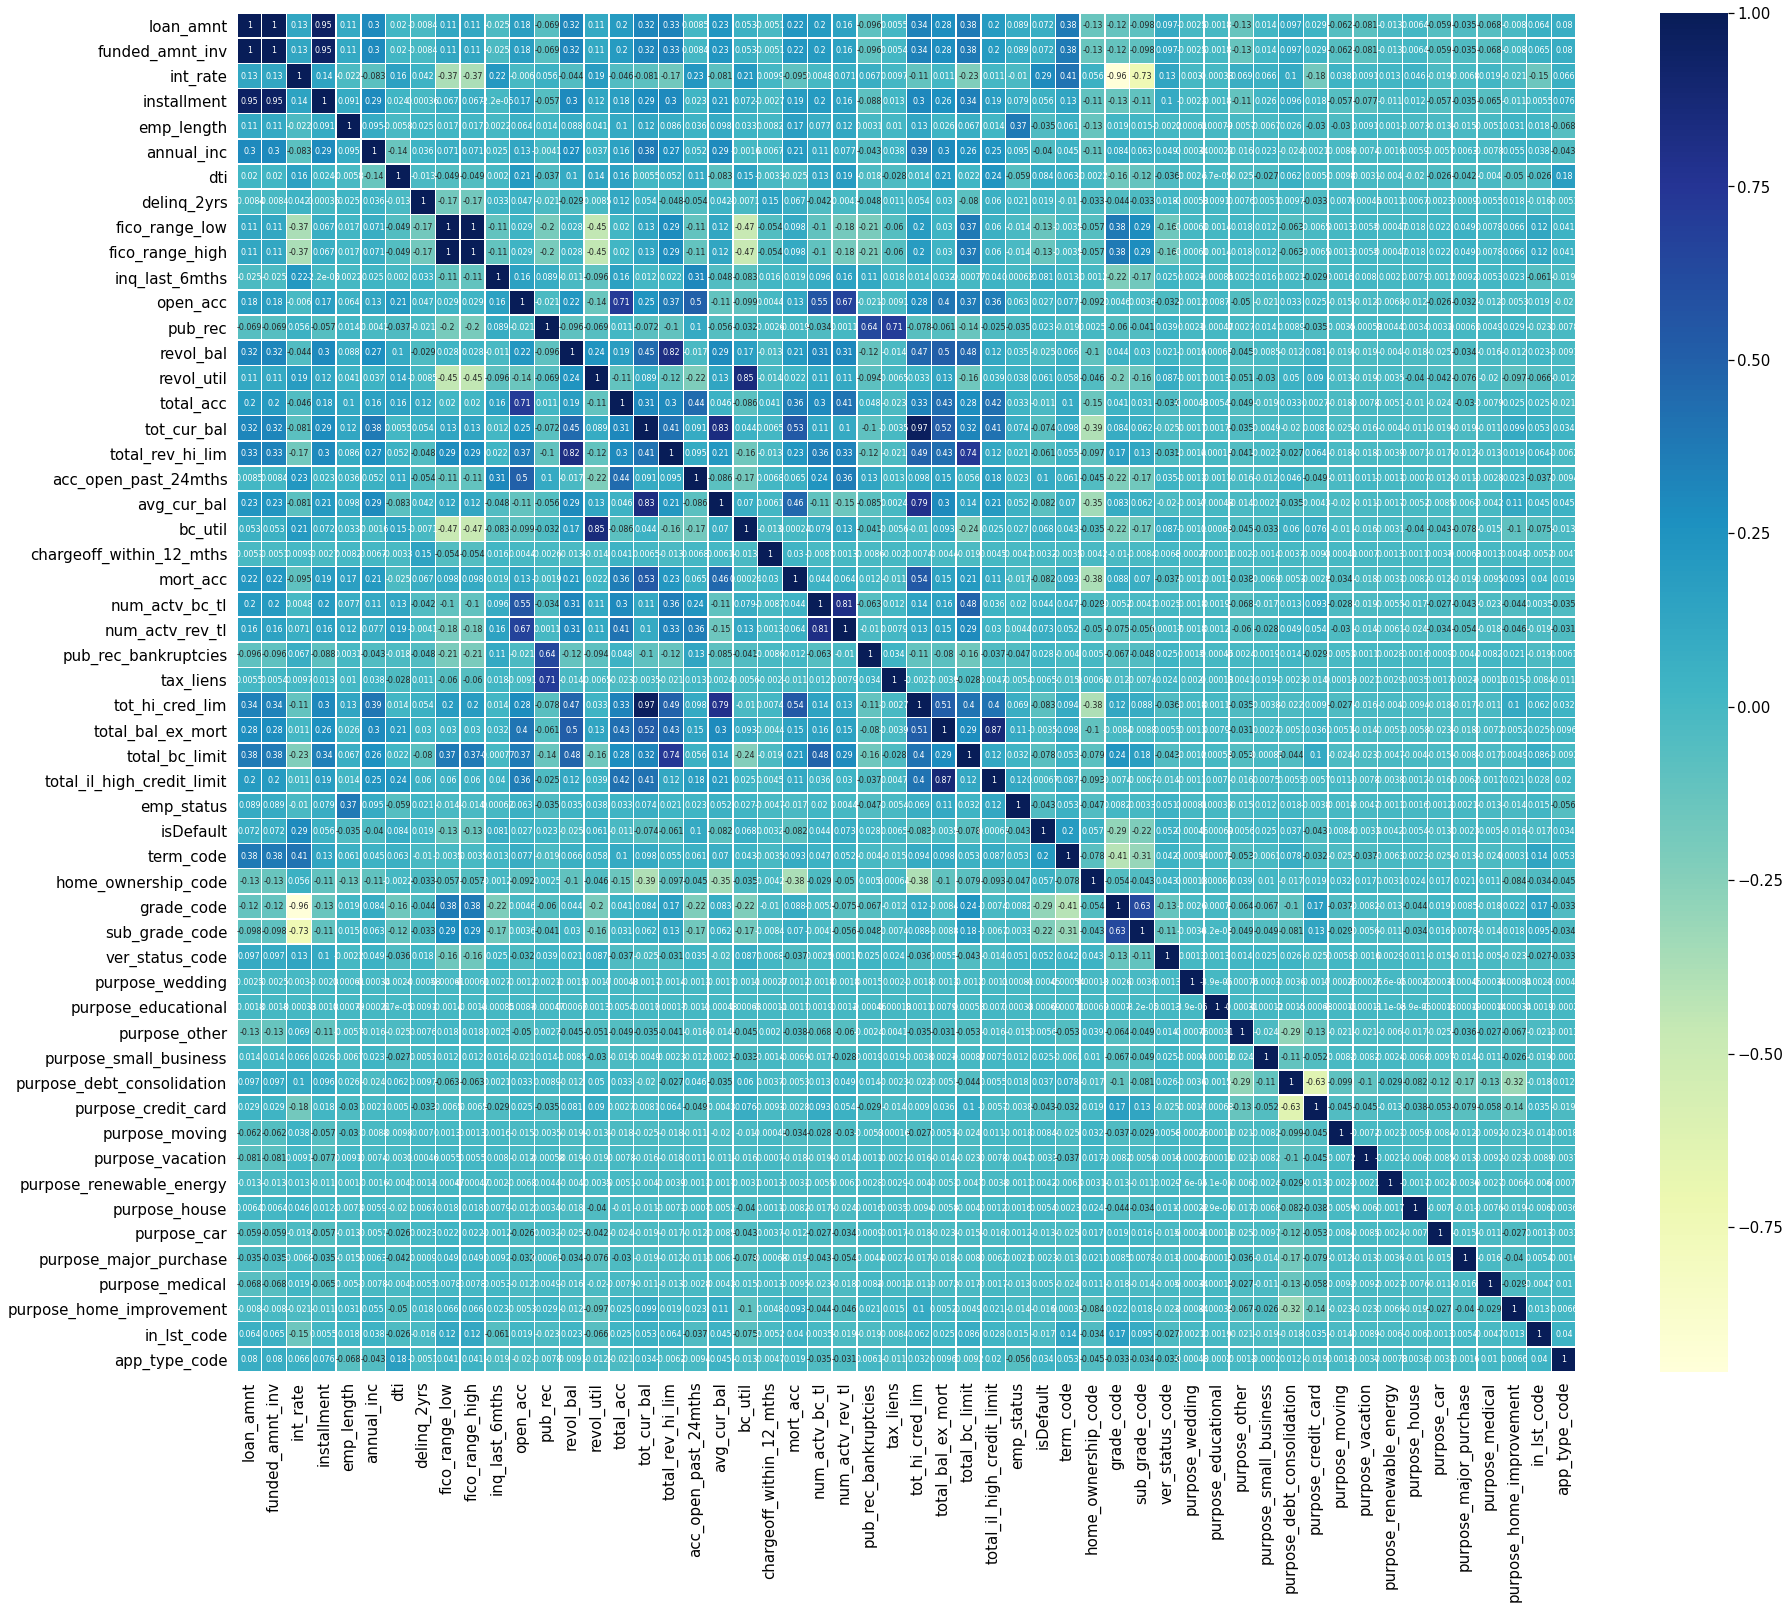

In [ ]:
#plot correlation matrix
sns.set(rc={"font.style":"normal",
            "axes.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":False,
            'axes.labelsize':30,
            'figure.figsize':(30, 25),
            'xtick.labelsize':15,
            'ytick.labelsize':15})

sns_plot = sns.heatmap(correlation_df_new, annot = True, annot_kws={"size": 8}, cmap="YlGnBu", linewidths=.5)

sns_plot
sns_plot.figure.savefig("corr_mat_new.png")

After some exploratory data analysis we have found that some variables have a very high correlation. These variables when used in our model could lead to an exceptionally good model performance. Therefore we have removed one of the two variables with correlation more than 0.7.

In [ ]:
import numpy as np

indices = np.where(abs(correlation_df_new) > 0.7)
high_corr_list = [(correlation_df_new.index[x], correlation_df_new.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]

high_corr_list

[('loan_amnt', 'funded_amnt_inv'),
 ('loan_amnt', 'installment'),
 ('funded_amnt_inv', 'installment'),
 ('int_rate', 'grade_code'),
 ('int_rate', 'sub_grade_code'),
 ('fico_range_low', 'fico_range_high'),
 ('open_acc', 'total_acc'),
 ('pub_rec', 'tax_liens'),
 ('revol_bal', 'total_rev_hi_lim'),
 ('revol_util', 'bc_util'),
 ('tot_cur_bal', 'avg_cur_bal'),
 ('tot_cur_bal', 'tot_hi_cred_lim'),
 ('total_rev_hi_lim', 'total_bc_limit'),
 ('avg_cur_bal', 'tot_hi_cred_lim'),
 ('num_actv_bc_tl', 'num_actv_rev_tl'),
 ('total_bal_ex_mort', 'total_il_high_credit_limit')]

In [ ]:
#drop one of the columns from high correlation pair
data_df_new = data_df_new.drop('funded_amnt_inv','installment','int_rate','sub_grade_code','total_acc','tax_liens','total_rev_hi_lim','bc_util','percent_bc_gt_75','avg_cur_bal','tot_hi_cred_lim', \
                                 'total_bc_limit', 'num_actv_bc_tl','total_il_high_credit_limit', 'out_prncp_inv')

In [ ]:
print((data_df_new.count(), len(data_df_new.columns)))

data_df_new.show(5)

(624778, 45)
+---------+----------+----------+------------------+----------+-----+-----------+----------------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-----------+--------------------+------------------------+--------+---------------+--------------------+-----------------+----------+---------+---------+-------------------+----------+---------------+---------------+-------------------+-------------+----------------------+--------------------------+-------------------+--------------+----------------+------------------------+-------------+-----------+----------------------+---------------+------------------------+-----------+-------------+
|loan_amnt|emp_length|annual_inc|           purpose|addr_state|  dti|delinq_2yrs|earliest_cr_line|fico_range_low|fico_range_high|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|out_prncp|tot_cur_bal|acc_open_past_24mths|chargeoff_within_12_mths|mort_acc|num_actv_rev_tl|pub_rec_bankruptcies|total

In [ ]:
data_df_new = data_df_new.withColumn("fico_range_avg", ((col("fico_range_low")+col("fico_range_high"))/2).cast(IntegerType()))

data_df_new = data_df_new.drop('loan_status','fico_range_low','fico_range_high','purpose','addr_state','earliest_cr_line')

print((data_df_new.count(), len(data_df_new.columns)))

data_df_new.show(5)

(624778, 41)
+---------+----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+-----------+--------------------+------------------------+--------+---------------+--------------------+-----------------+----------+---------+---------+-------------------+----------+---------------+---------------+-------------------+-------------+----------------------+--------------------------+-------------------+--------------+----------------+------------------------+-------------+-----------+----------------------+---------------+------------------------+-----------+-------------+--------------+
|loan_amnt|emp_length|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|out_prncp|tot_cur_bal|acc_open_past_24mths|chargeoff_within_12_mths|mort_acc|num_actv_rev_tl|pub_rec_bankruptcies|total_bal_ex_mort|emp_status|isDefault|term_code|home_ownership_code|grade_code|ver_status_code|purpose_wedding|purpose_educational|purpose_other|

In [ ]:
data_df_new.printSchema()

root
 |-- loan_amnt: float (nullable = true)
 |-- emp_length: integer (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- pub_rec: integer (nullable = true)
 |-- revol_bal: float (nullable = true)
 |-- revol_util: float (nullable = true)
 |-- out_prncp: string (nullable = true)
 |-- tot_cur_bal: float (nullable = true)
 |-- acc_open_past_24mths: integer (nullable = true)
 |-- chargeoff_within_12_mths: integer (nullable = true)
 |-- mort_acc: integer (nullable = true)
 |-- num_actv_rev_tl: integer (nullable = true)
 |-- pub_rec_bankruptcies: integer (nullable = true)
 |-- total_bal_ex_mort: float (nullable = true)
 |-- emp_status: integer (nullable = false)
 |-- isDefault: integer (nullable = false)
 |-- term_code: integer (nullable = false)
 |-- home_ownership_code: integer (nullable = false)
 |-- grade_code: i

After all of the above cleaning we are left with 40 variables. We have used these 40 variables for our future predictions. To confirm we have again computed the correlation matrix for the remaining 40 variables to check if there are any highly correlated variables present.

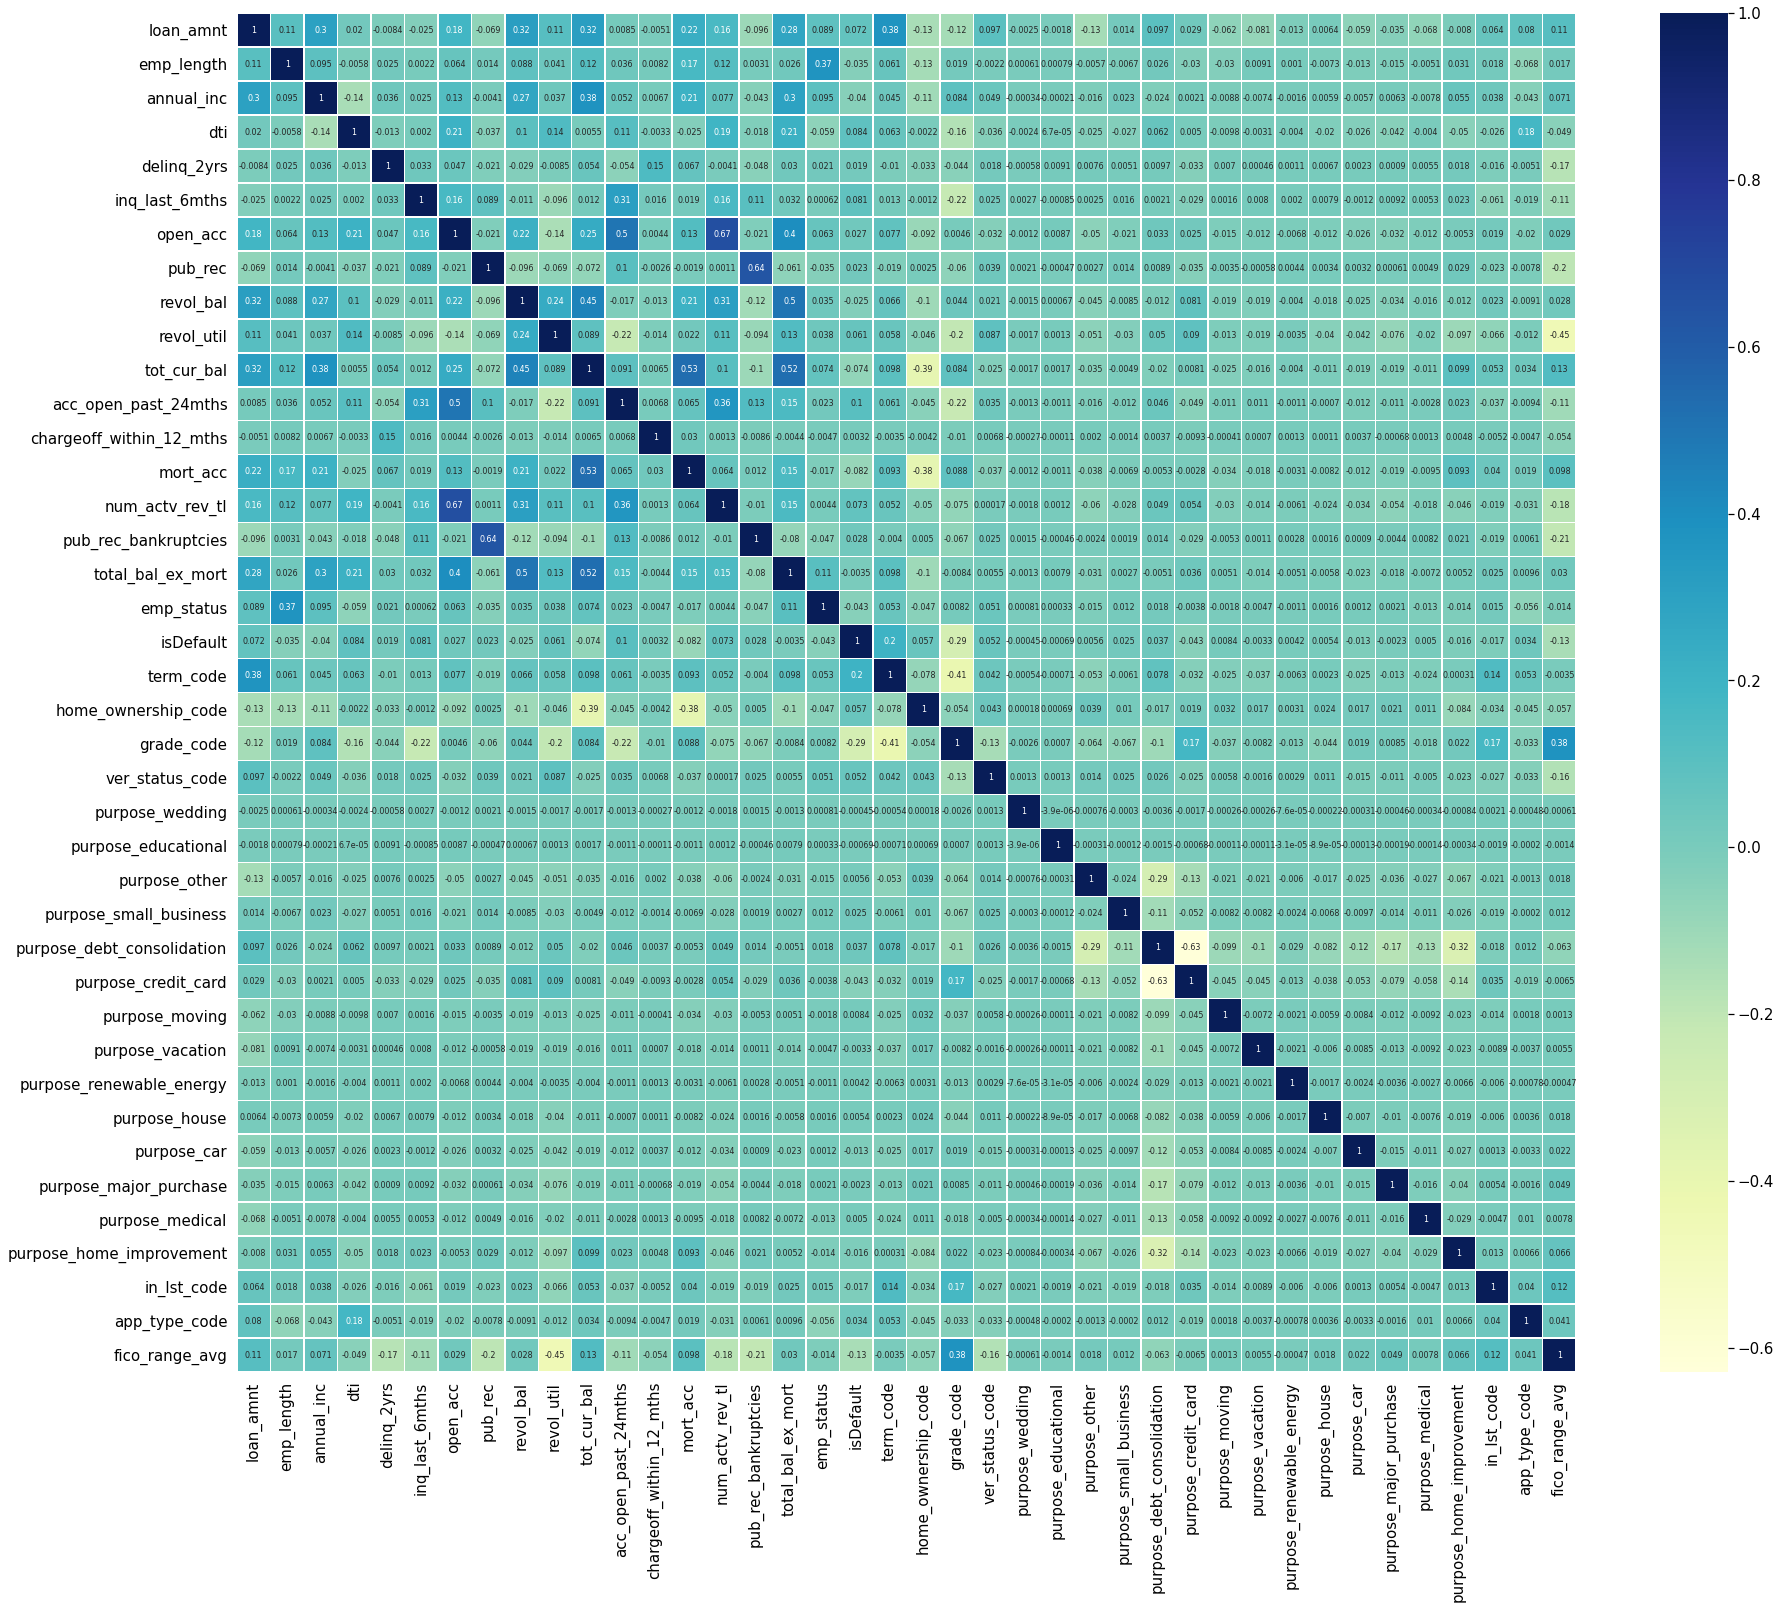

In [ ]:
correlation_df_new_1 = data_df_new.toPandas().corr()

#correlation_df
sns.set(rc={"font.style":"normal",
            "axes.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":False,
            'axes.labelsize':30,
            'figure.figsize':(30, 25),
            'xtick.labelsize':15,
            'ytick.labelsize':15})

sns_plot = sns.heatmap(correlation_df_new_1, annot = True, annot_kws={"size": 8}, cmap="YlGnBu", linewidths=.5)

sns_plot
sns_plot.figure.savefig("corr_mat_new_1.png")

In [ ]:
loanDFForModel = data_df_new

In [ ]:
#DataProcessing for Linear Regression on ROI


import pyspark.sql.functions as F
from pyspark.sql.functions import isnan, isnull, when, count, col
from pyspark.sql.functions import split
threshold=data_df_1.count()*0.3

def drop_null_columns(df):
    """
    This function drops all columns which contain null values.
    :param df: A PySpark DataFrame
    """
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v > threshold]
    df = df.drop(*to_drop)
    return df

data_df_2 = drop_null_columns(data_df_1)

data_df_2=data_df_2.dropna(how='any')
data_df_3 = data_df_2.withColumn("term", split(col("term"),"\s+").getItem(1))


In [ ]:
col_r=['funded_amnt_inv',
 'term',
 'int_rate',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'dti',
 'fico_range_low',
 'open_acc',
 'total_acc',
 'total_pymnt_inv',
 'installment',
 'tot_cur_bal',
 'disbursement_method']

data_df_4=data_df_3.select([column for column in data_df_3.columns if column in col_r])


In [ ]:
from pyspark.sql.types import FloatType

data_df_4 = data_df_4.withColumn("funded_amnt_inv", data_df_4["funded_amnt_inv"].cast(FloatType()))
data_df_4 = data_df_4.withColumn("int_rate", data_df_4["int_rate"].cast(FloatType()))
data_df_4 = data_df_4.withColumn("annual_inc", data_df_4["annual_inc"].cast(FloatType()))

data_df_4 = data_df_4.withColumn("installment", data_df_4["installment"].cast(FloatType()))
data_df_4 = data_df_4.withColumn("total_pymnt_inv", data_df_4["total_pymnt_inv"].cast(FloatType()))
data_df_4 = data_df_4.withColumn('return_inv', F.col('total_pymnt_inv') /F.col('funded_amnt_inv') )

data_df_4 = data_df_4.withColumn("dti", data_df_4["dti"].cast(FloatType()))

data_df_4 = data_df_4.withColumn("fico_range_low", data_df_4["fico_range_low"].cast(FloatType()))

data_df_4 = data_df_4.withColumn("open_acc", data_df_4["open_acc"].cast(FloatType()))

data_df_4 = data_df_4.withColumn("total_acc", data_df_4["total_acc"].cast(FloatType()))

data_df_4 = data_df_4.withColumn("tot_cur_bal", data_df_4["tot_cur_bal"].cast(FloatType()))

In [ ]:

from pyspark.ml import feature, regression, evaluation, Pipeline



term_i = feature.StringIndexerModel.from_labels(['36', '60'],inputCol="term",
                                    outputCol="term_idx")

grade_i = feature.StringIndexerModel.from_labels(['A', 'B', 'C', 'D', 'E','F','G'],inputCol="grade",
                                    outputCol="grade_idx")

emp_length_i = feature.StringIndexerModel.from_labels(['< 1 year', '1 year', '2 years', '3 years', '4 years','5 years','6 years','7 years','8 years','9 years','10+ years'],inputCol="emp_length",
                                    outputCol="emp_length_idx")

home_ownership_i = feature.StringIndexerModel.from_labels(['OWN', 'RENT', 'MORTGAGE', 'ANY', 'NONE'],inputCol="home_ownership",
                                    outputCol="home_ownership_idx")

verification_status_i = feature.StringIndexerModel.from_labels(['Verified', 'Source Verified', 'Not Verified'],inputCol="verification_status",
                                    outputCol="verification_status_idx")

purpose_i = feature.StringIndexerModel.from_labels(['wedding', 'educational', 'small_business', 'debt_consolidation','credit_card','moving','vacation','renewable_energy','house','car','major_purchase','medical', 'home_improvement','other'],inputCol="purpose",
                                    outputCol="purpose_idx")

disbursement_method_i = feature.StringIndexerModel.from_labels(['Cash', 'DirectPay'],inputCol="disbursement_method",
                                    outputCol="disbursement_method_idx")


feature_engineering_pipe=Pipeline(stages=[term_i, grade_i, emp_length_i,home_ownership_i,verification_status_i,purpose_i,disbursement_method_i])



data_df_4_xformed = feature_engineering_pipe.fit(data_df_4).transform(data_df_4)
drop_cols = ['term','grade' ,'emp_length','home_ownership','verification_status','purpose','disbursement_method']
data_df_4_xformed = data_df_4_xformed.drop(*drop_cols)

data_df_4_xformed = data_df_4_xformed.withColumnRenamed("term_idx", "term").withColumnRenamed("grade_idx", "grade").withColumnRenamed("emp_length_idx", "emp_length").withColumnRenamed("home_ownership_idx", "home_ownership").withColumnRenamed("verification_status_idx", "verification_status").withColumnRenamed("purpose_idx", "purpose").withColumnRenamed("disbursement_method_idx", "disbursement_method")
                        


In [ ]:
training_df, testing_df = data_df_4_xformed.randomSplit([0.8, 0.2], seed=12345)


## Prediction 1: Probability that a given borrower returns the loan

In [ ]:
colList = loanDFForModel.columns
pred2_colList = colList
print(colList)
print(len(colList))

['loan_amnt', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'out_prncp', 'tot_cur_bal', 'acc_open_past_24mths', 'chargeoff_within_12_mths', 'mort_acc', 'num_actv_rev_tl', 'pub_rec_bankruptcies', 'total_bal_ex_mort', 'emp_status', 'isDefault', 'term_code', 'home_ownership_code', 'grade_code', 'ver_status_code', 'purpose_wedding', 'purpose_educational', 'purpose_other', 'purpose_small_business', 'purpose_debt_consolidation', 'purpose_credit_card', 'purpose_moving', 'purpose_vacation', 'purpose_renewable_energy', 'purpose_house', 'purpose_car', 'purpose_major_purchase', 'purpose_medical', 'purpose_home_improvement', 'in_lst_code', 'app_type_code', 'fico_range_avg']
41


In [ ]:
colList.remove('out_prncp')
colList.remove('isDefault')
print(colList)
print(len(colList))

['loan_amnt', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'tot_cur_bal', 'acc_open_past_24mths', 'chargeoff_within_12_mths', 'mort_acc', 'num_actv_rev_tl', 'pub_rec_bankruptcies', 'total_bal_ex_mort', 'emp_status', 'term_code', 'home_ownership_code', 'grade_code', 'ver_status_code', 'purpose_wedding', 'purpose_educational', 'purpose_other', 'purpose_small_business', 'purpose_debt_consolidation', 'purpose_credit_card', 'purpose_moving', 'purpose_vacation', 'purpose_renewable_energy', 'purpose_house', 'purpose_car', 'purpose_major_purchase', 'purpose_medical', 'purpose_home_improvement', 'in_lst_code', 'app_type_code', 'fico_range_avg']
39


In the next few cells we have performed the pre-processing steps needed to build any models like vector assembler and scaling and centering the data.

Since our data is skewed we have computed a weight factor which is the ratio of number of Default and nonDefault rows.

In [ ]:
from pyspark.ml.feature import VectorAssembler

# set the input and output column names
assembler = VectorAssembler(inputCols=[ *colList ], outputCol="features")

loanDFForModel = assembler.transform( loanDFForModel)

loanDFForModel.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|(39,[0,1,2,3,5,6,...|
|(39,[0,1,2,3,4,5,...|
|(39,[0,1,2,3,6,8,...|
|(39,[0,1,2,3,4,5,...|
|(39,[0,1,2,3,6,8,...|
+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
loanDFForModel=standardscaler.fit(loanDFForModel).transform(loanDFForModel)
loanDFForModel.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|(39,[0,1,2,3,5,6,...|(39,[0,1,2,3,5,6,...|
|(39,[0,1,2,3,4,5,...|(39,[0,1,2,3,4,5,...|
|(39,[0,1,2,3,6,8,...|(39,[0,1,2,3,6,8,...|
|(39,[0,1,2,3,4,5,...|(39,[0,1,2,3,4,5,...|
|(39,[0,1,2,3,6,8,...|(39,[0,1,2,3,6,8,...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
loanDFForModel.show(5)

+---------+----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+-----------+--------------------+------------------------+--------+---------------+--------------------+-----------------+----------+---------+---------+-------------------+----------+---------------+---------------+-------------------+-------------+----------------------+--------------------------+-------------------+--------------+----------------+------------------------+-------------+-----------+----------------------+---------------+------------------------+-----------+-------------+--------------+--------------------+--------------------+
|loan_amnt|emp_length|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|out_prncp|tot_cur_bal|acc_open_past_24mths|chargeoff_within_12_mths|mort_acc|num_actv_rev_tl|pub_rec_bankruptcies|total_bal_ex_mort|emp_status|isDefault|term_code|home_ownership_code|grade_code|ver_status_code|purpose_wedding|purpo

In [ ]:
training_df, testing_df = loanDFForModel.randomSplit([0.8, 0.2], seed=12345)
training_df.show(5)

+---------+----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+-----------+--------------------+------------------------+--------+---------------+--------------------+-----------------+----------+---------+---------+-------------------+----------+---------------+---------------+-------------------+-------------+----------------------+--------------------------+-------------------+--------------+----------------+------------------------+-------------+-----------+----------------------+---------------+------------------------+-----------+-------------+--------------+--------------------+--------------------+
|loan_amnt|emp_length|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|out_prncp|tot_cur_bal|acc_open_past_24mths|chargeoff_within_12_mths|mort_acc|num_actv_rev_tl|pub_rec_bankruptcies|total_bal_ex_mort|emp_status|isDefault|term_code|home_ownership_code|grade_code|ver_status_code|purpose_wedding|purpo

In [ ]:
training_df.groupby("isDefault").count().show()

+---------+------+
|isDefault| count|
+---------+------+
|        1|113739|
|        0|386264|
+---------+------+



In [ ]:
BalancingRatio= 113739/(113739+386264)
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.22747663514018915


In [ ]:
training_df = training_df.withColumn("weightColumn", when(col("isDefault") == 1, BalancingRatio)
                                           .otherwise((1-BalancingRatio)))

In [ ]:
training_df.show(5)

+---------+----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+-----------+--------------------+------------------------+--------+---------------+--------------------+-----------------+----------+---------+---------+-------------------+----------+---------------+---------------+-------------------+-------------+----------------------+--------------------------+-------------------+--------------+----------------+------------------------+-------------+-----------+----------------------+---------------+------------------------+-----------+-------------+--------------+--------------------+--------------------+-------------------+
|loan_amnt|emp_length|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|out_prncp|tot_cur_bal|acc_open_past_24mths|chargeoff_within_12_mths|mort_acc|num_actv_rev_tl|pub_rec_bankruptcies|total_bal_ex_mort|emp_status|isDefault|term_code|home_ownership_code|grade_code|ver_status_code|p


### Logistic Regression

Here we have built a Logisitic regression model. We see that the most important features for predicting default status are loan grade and term of the loan. The coeffecient for grade_code is negative which means that the higher the grade it is less likely that the loan will be default, whereas the coeffecient for term is positive which means the higher the term duration it is more likely that the loan will be a default loan.

In [ ]:
# your code here
from pyspark.ml.classification import LogisticRegression

#from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="isDefault", featuresCol="Scaled_features", weightCol="weightColumn")
lr_model=lr.fit(training_df)
lr_df=lr_model.transform(training_df)
lr_df.show(5)

+---------+----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+-----------+--------------------+------------------------+--------+---------------+--------------------+-----------------+----------+---------+---------+-------------------+----------+---------------+---------------+-------------------+-------------+----------------------+--------------------------+-------------------+--------------+----------------+------------------------+-------------+-----------+----------------------+---------------+------------------------+-----------+-------------+--------------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+
|loan_amnt|emp_length|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|out_prncp|tot_cur_bal|acc_open_past_24mths|chargeoff_within_12_mths|mort_acc|num_actv_rev_tl|pub_rec_bankruptcies|total_bal_ex_mort|emp_status|isDefault|term_

In [ ]:
# Train prediction
from pyspark.ml.evaluation import RegressionEvaluator
train_evaluater = RegressionEvaluator(labelCol='isDefault', 
                                      predictionCol='prediction', 
                                      metricName='rmse')
lr_train_mse = train_evaluater.evaluate(lr_df)
print("Root Mean Squared Error (RMSE) on training data = %g" % lr_train_mse)
# Make predictions.
lr_predictions = lr_model.transform(testing_df)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="isDefault", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE) on testing data = %g" % mse)

Root Mean Squared Error (RMSE) on training data = 0.476704
Root Mean Squared Error (RMSE) on testing data = 0.477253


In [ ]:
#lr_model = inference_pipe.stages[-1]

lr_feature_importance = pd.DataFrame(list(zip(colList,
                                              lr_model.coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending=False)
lr_feature_formap = pd.DataFrame(list(zip(colList,
                                              abs(lr_model.coefficients.toArray()))),
            columns = ['column', 'weight']).sort_values('weight', ascending=False)

In [ ]:
display(lr_feature_importance)

,column,weight
26,purpose_debt_consolidation,1.222649
27,purpose_credit_card,1.010163
35,purpose_home_improvement,0.633488
24,purpose_other,0.596464
33,purpose_major_purchase,0.371332
34,purpose_medical,0.286666
18,term_code,0.279885
25,purpose_small_business,0.273118
32,purpose_car,0.238675
28,purpose_moving,0.221954


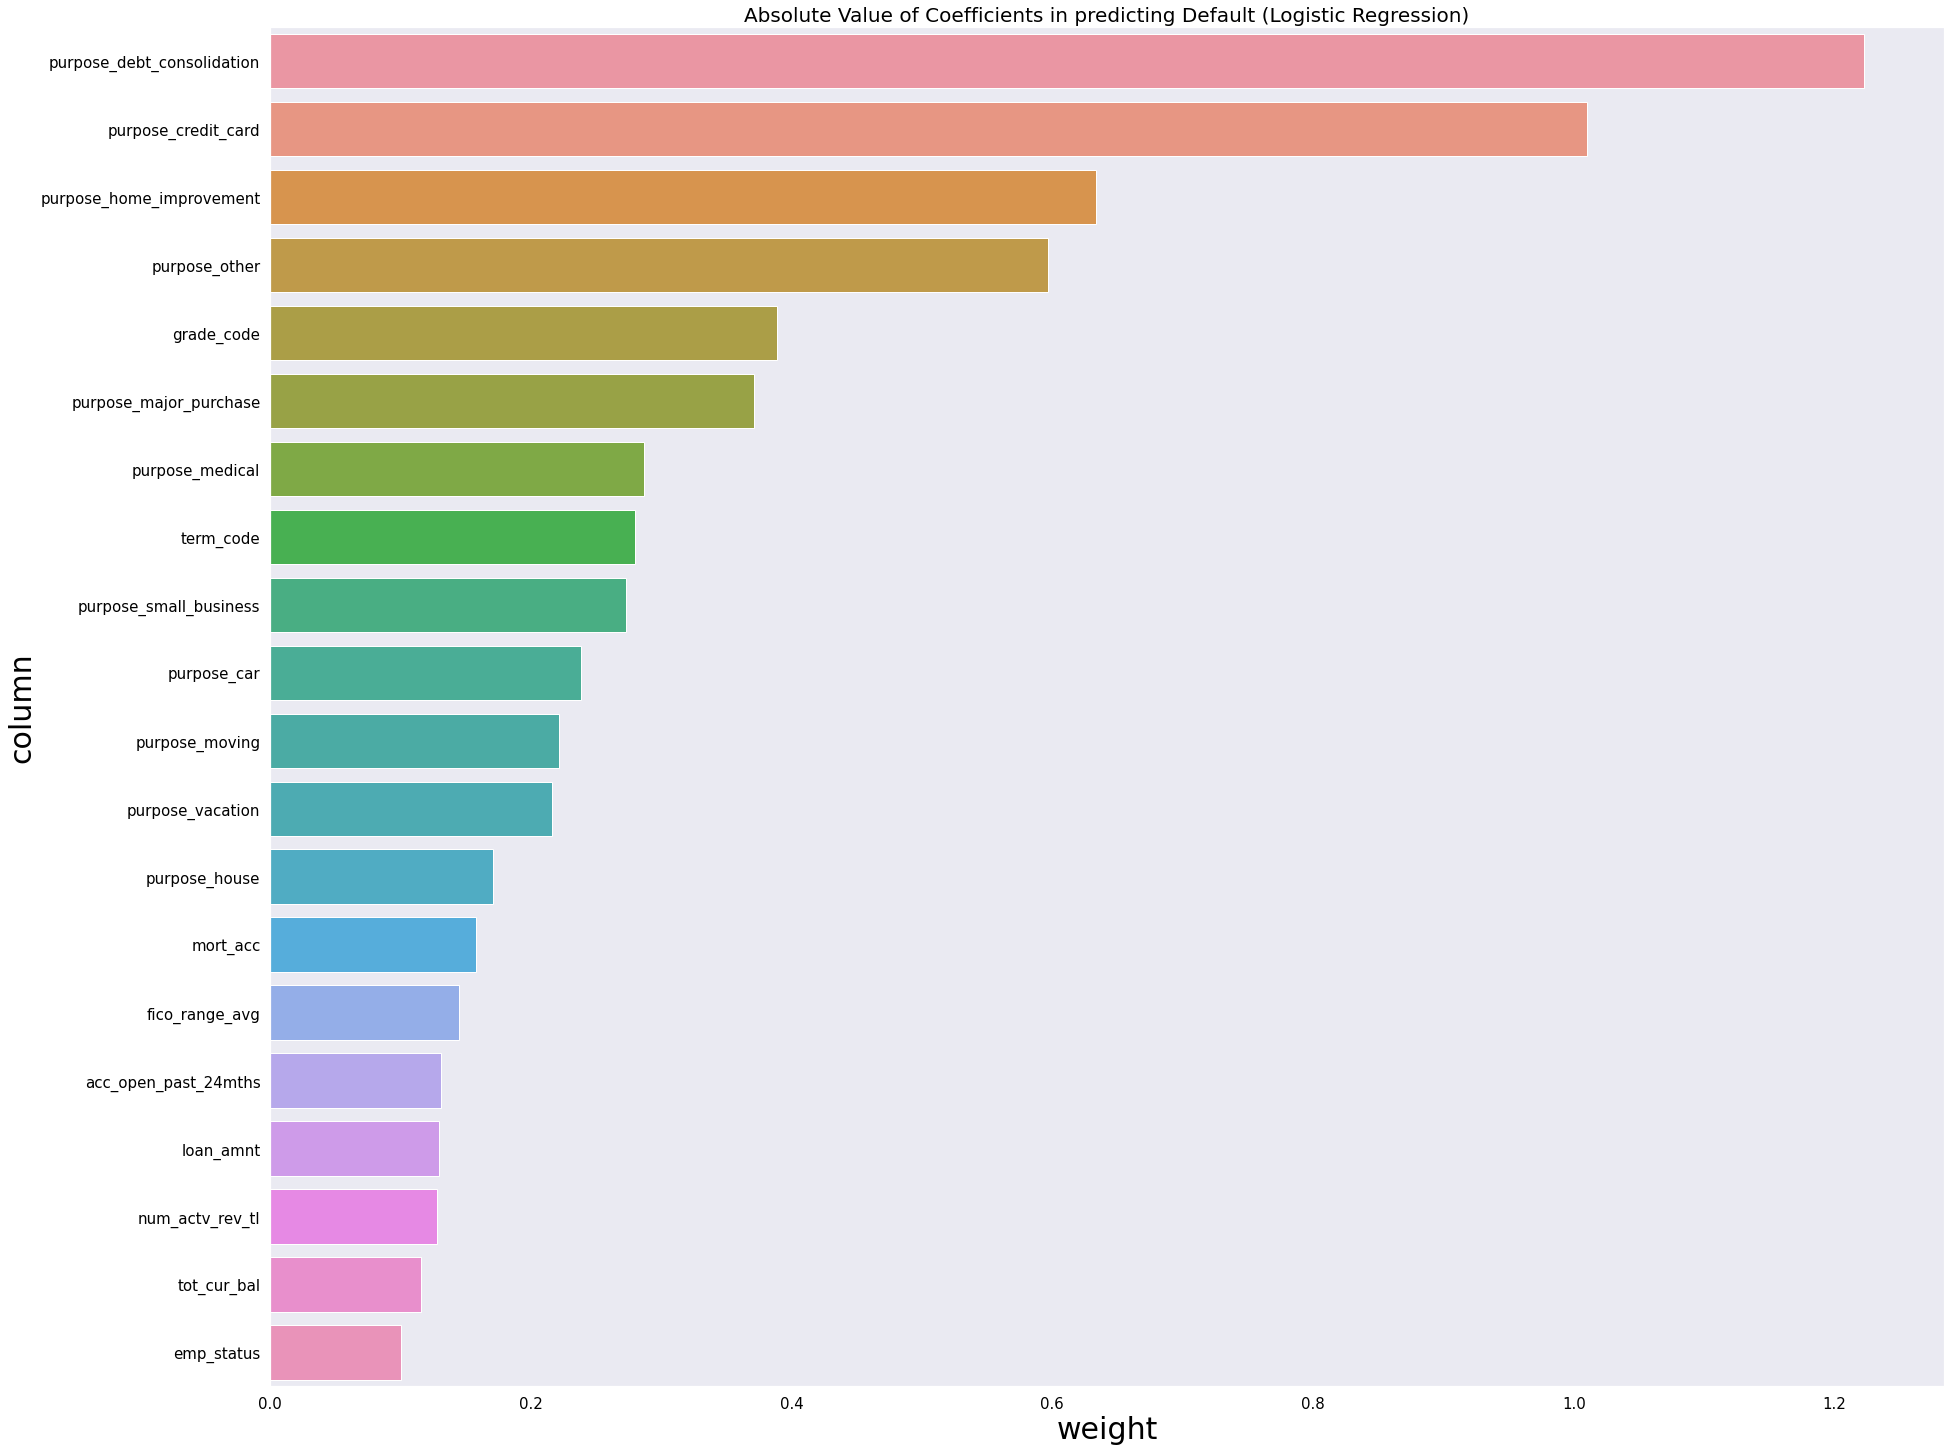

In [ ]:
lr_feat_plot = sns.barplot(y=lr_feature_formap['column'][:20], x=lr_feature_formap['weight'][:20])
plt.title("Absolute Value of Coefficients in predicting Default (Logistic Regression)")
lr_feat_plot.figure.savefig('lr_feature_imp.png')
plt.show()

In [ ]:
#Accuracy of Logistic Regression Model
lr_df.\
    select(F.expr('float(prediction = isDefault)').alias('correct')).\
    select(F.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.7727533634798192|
+------------------+



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# use the evaluator
evaluator = BinaryClassificationEvaluator(labelCol='isDefault')

# fetch auc value
auroc = evaluator.evaluate(lr_df, {evaluator.metricName: "areaUnderROC"})

print("Area under ROC Curve: {:.4f}".format(auroc))

Area under ROC Curve: 0.7222


In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def createROC(predictions):
    results = predictions.select(['probability', 'isDefault'])
 
    ## prepare score-label set
    results_collect = results.collect()
    results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
    scoreAndLabels = spark.sparkContext.parallelize(results_list)
 
    bcMetrics = BinaryClassificationMetrics(scoreAndLabels)
    print("ROC score is - ", bcMetrics.areaUnderROC)
        
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
 
    y_test = [i[1] for i in results_list]
    y_score = [i[0] for i in results_list]
 
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
 
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for Loan Analysis')
    plt.legend(loc="lower right")
    plt.show()

    plt.savefig("LoanROC.pdf")

ROC score is -  0.7221772325784408


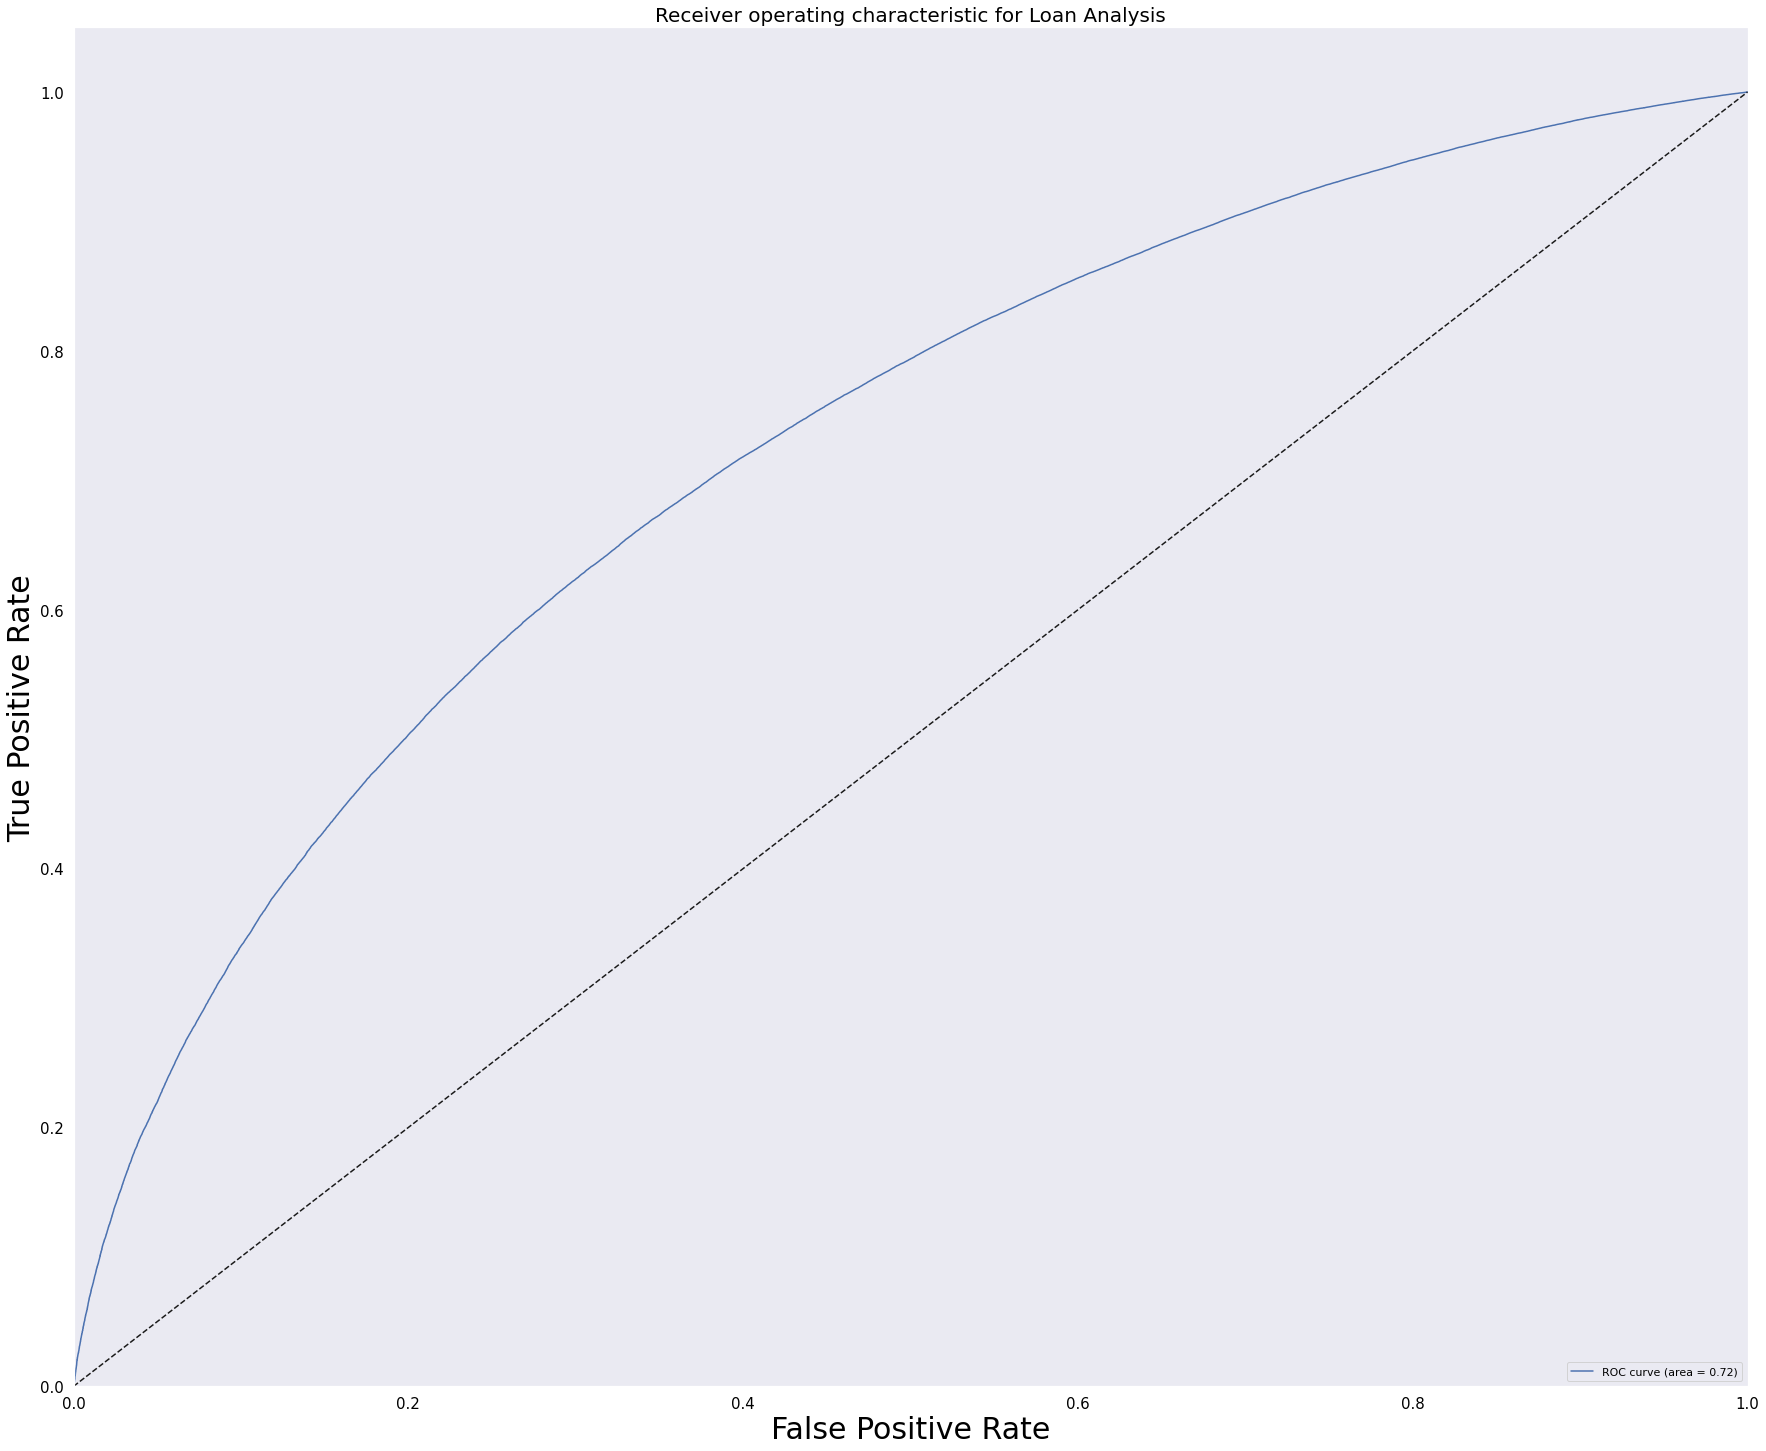

<Figure size 2160x1800 with 0 Axes>

In [ ]:
createROC(lr_df)

### Random Forest

In the following section we have built a Random Forest regressor model to predict the loan status. we have used grid search for tuning the hyperparameters and used 3-fold cross validation and root-mean squared error as a performance metric to find the best hyperparameters. 

The best model also gives result similar to the logistic regression with grade of loan and term as the most important features to predict the loan status.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="Scaled_features", labelCol='isDefault',
                           weightCol="weightColumn")

if enable_grid_search:
  diamond_pipe = Pipeline(stages=[rf]).fit(training_df)
  diamond_pipe_estimator = Pipeline(stages=[rf])
  paramGrid = ParamGridBuilder().\
    addGrid(diamond_pipe.stages[-1].numTrees, [10, 30, 50]).\
    addGrid(diamond_pipe.stages[-1].maxDepth, [0, 1, 2, 5]).\
    addGrid(diamond_pipe.stages[-1].seed, [7]).\
    build()

  evaluator = RegressionEvaluator(
    labelCol="isDefault", predictionCol="prediction", metricName="rmse")
  crossval = CrossValidator(estimator=diamond_pipe_estimator, 
                            estimatorParamMaps=paramGrid, 
                            evaluator=evaluator, 
                            numFolds=3)
  rf_model = crossval.fit(training_df)
  print("-----------------------------------")
  print("RMSE of the crossvalidation model = %g" % min(rf_model.avgMetrics))

  best_idx = np.argmin(rf_model.avgMetrics)
  print(paramGrid[best_idx])
  pass

In [ ]:
rf = RandomForestRegressor(featuresCol="Scaled_features", labelCol='isDefault',
                            weightCol="weightColumn",
                           numTrees=10, maxDepth=5, seed=7)
lending_pipe = rf.fit(training_df)

# Train prediction
pred_train = lending_pipe.transform(training_df)
train_evaluater = RegressionEvaluator(labelCol='isDefault', 
                                      predictionCol='prediction', 
                                      metricName='rmse')
rf_train_mse = train_evaluater.evaluate(pred_train)
print("Root Mean Squared Error (RMSE) on training data = %g" % rf_train_mse)
# Make predictions.
rf_predictions = lending_pipe.transform(testing_df)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="isDefault", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % mse) 

Root Mean Squared Error (RMSE) on training data = 0.428725
Root Mean Squared Error (RMSE) on test data = 0.429455


In [ ]:
import pandas as pd

rf_model = lending_pipe

rf_feature_importance = pd.DataFrame(list(zip(colList,
                                              rf_model.featureImportances.\
                                                toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending=False)

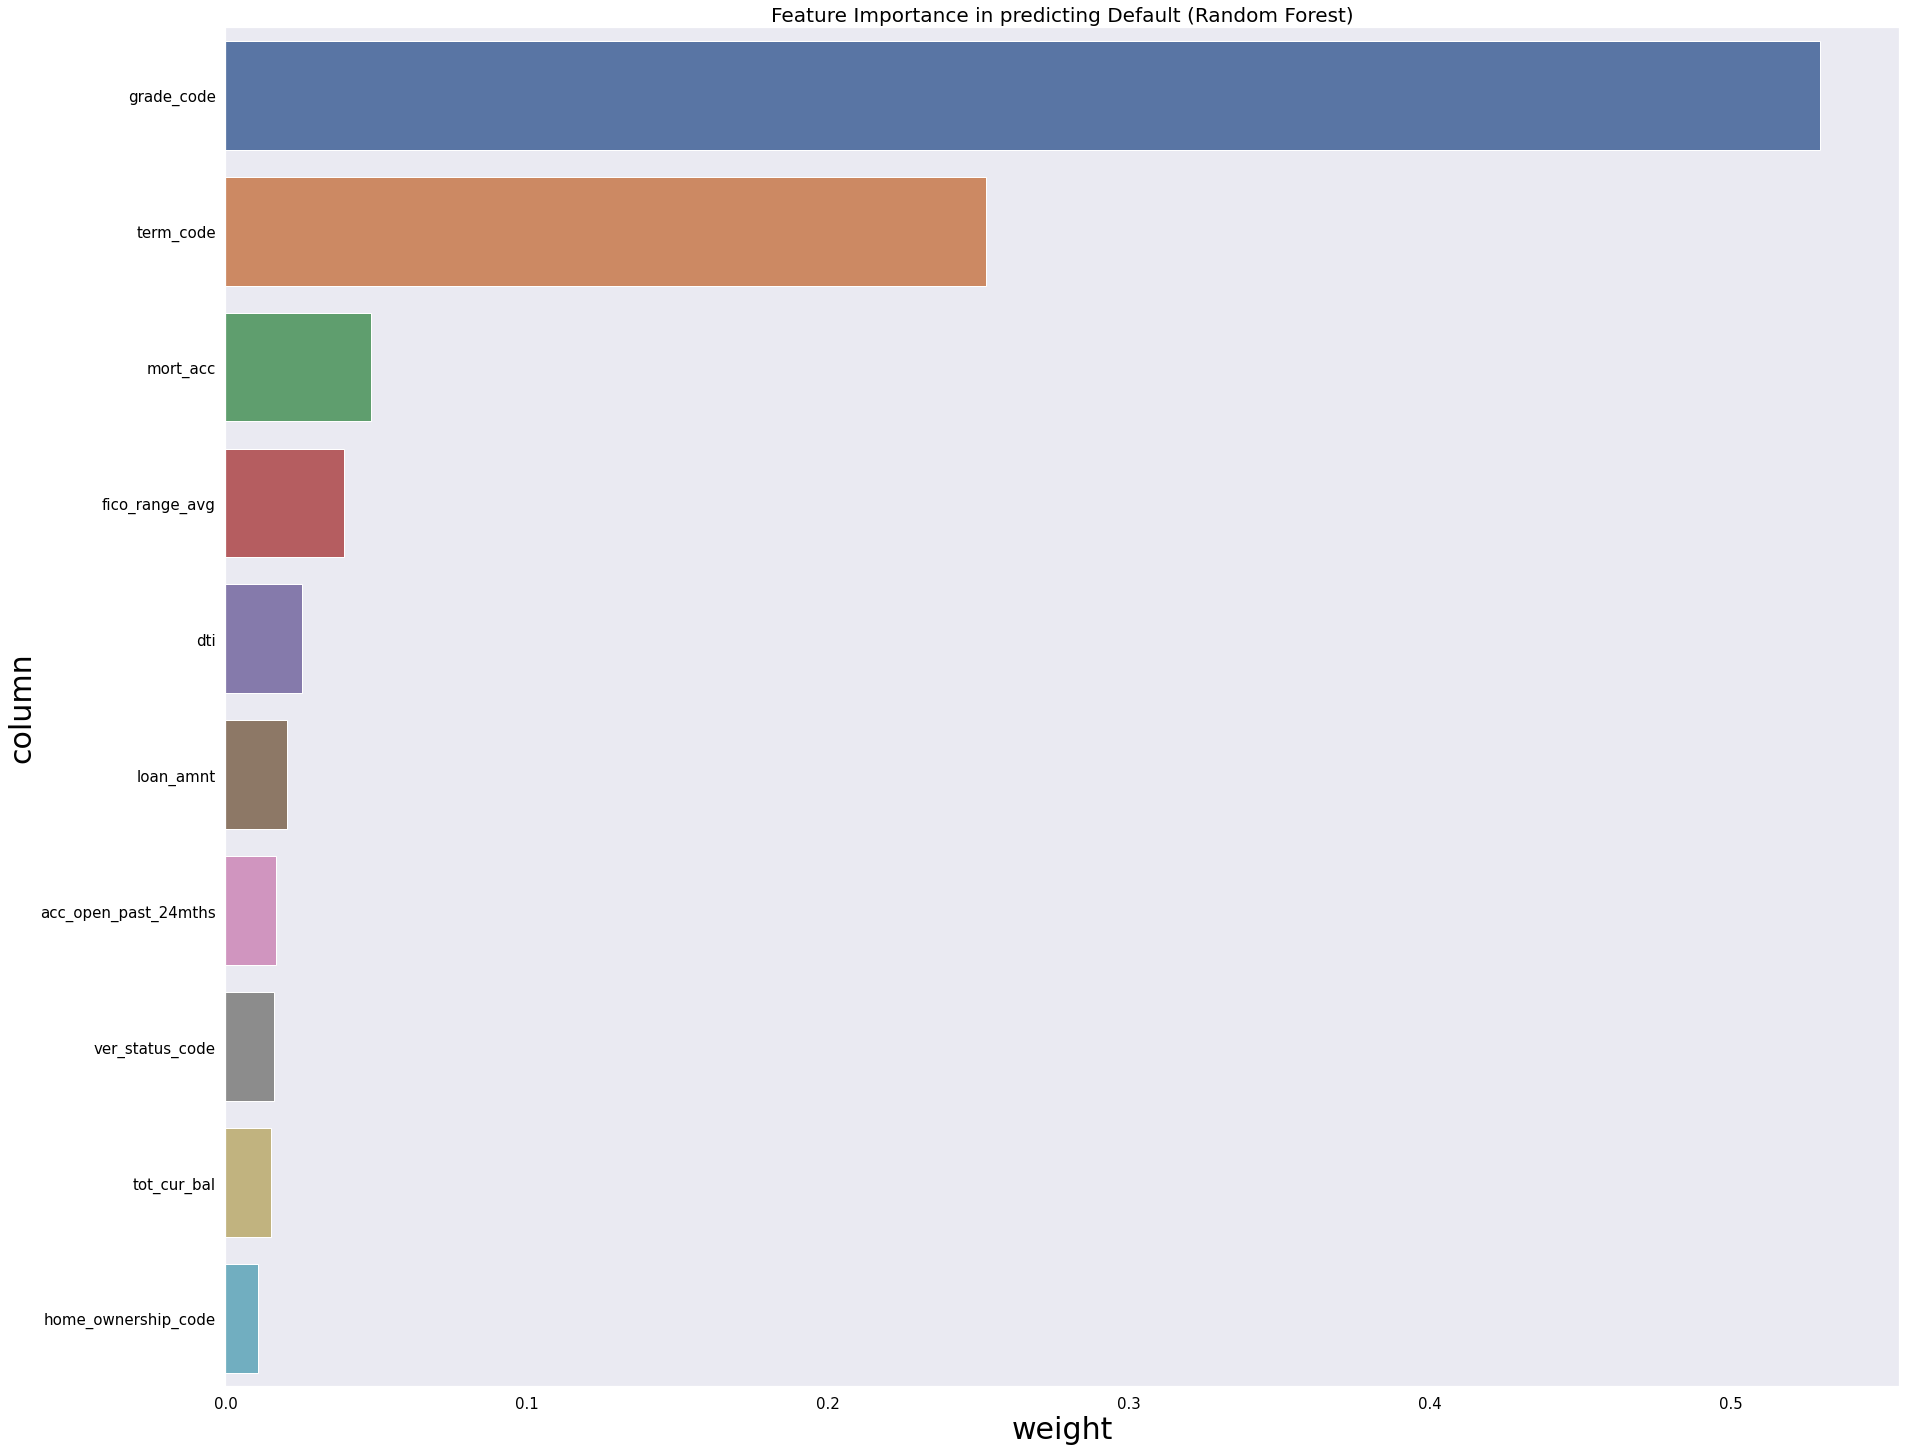

In [ ]:
sns.barplot(y=rf_feature_importance['column'][:10], x=rf_feature_importance['weight'][:10])
plt.title("Feature Importance in predicting Default (Random Forest)")
plt.show()

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
pred_train = pred_train.withColumn("prediction", F.round(pred_train["prediction"], 0))
pred_label = pred_train.selectExpr("cast(prediction as int) prediction", "isDefault")

In [ ]:
#Accuracy of Random Forest
pred_label.\
    select(F.expr('float(prediction = isDefault)').alias('correct')).\
    select(F.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.7725233648598109|
+------------------+



### Gradiant Boosted Tree Regressor

Finally we have built a Gradiant boosted regressor model using grid search for tuning the hyperparameters and using rmse as a performance metric. The best model gives a performance which is better than both the Random forest and logistic regression. The best feature according to this model is grade of the loan and the loan amount.

In [ ]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="Scaled_features", labelCol='isDefault',
                           weightCol="weightColumn")

if enable_grid_search:
  diamond_pipe = Pipeline(stages=[gbt]).fit(training_df)
  diamond_pipe_estimator = Pipeline(stages=[gbt])
  paramGrid = ParamGridBuilder().\
    addGrid(diamond_pipe.stages[-1].maxIter, [10, 100]).\
    addGrid(diamond_pipe.stages[-1].maxDepth, [0, 1, 2, 5]).\
    addGrid(diamond_pipe.stages[-1].seed, [7]).\
    build()

  evaluator = RegressionEvaluator(
    labelCol="isDefault", predictionCol="prediction", metricName="rmse")
  crossval = CrossValidator(estimator=diamond_pipe_estimator, 
                            estimatorParamMaps=paramGrid, 
                            evaluator=evaluator, 
                            numFolds=3)
  rf_model = crossval.fit(training_df)
  print("-----------------------------------")
  print("RMSE of the crossvalidation model = %g" % min(rf_model.avgMetrics))

  best_idx = np.argmin(rf_model.avgMetrics)
  print(paramGrid[best_idx])
  pass

In [ ]:
gbt = GBTRegressor(featuresCol="Scaled_features", labelCol='isDefault',
                            weightCol="weightColumn",
                           maxIter=100, maxDepth=5, seed=7)
lending_pipe = gbt.fit(training_df)

# Train prediction
pred_train = lending_pipe.transform(training_df)
train_evaluater = RegressionEvaluator(labelCol='isDefault', 
                                      predictionCol='prediction', 
                                      metricName='rmse')
gbt_train_mse = train_evaluater.evaluate(pred_train)
print("Root Mean Squared Error (RMSE) on training data = %g" % gbt_train_mse)
# Make predictions.
rf_predictions = lending_pipe.transform(testing_df)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="isDefault", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on testing data = %g" % mse)

Root Mean Squared Error (RMSE) on training data = 0.421251
Root Mean Squared Error (RMSE) on testing data = 0.423717


In [ ]:
gbt_model = lending_pipe

gbt_feature_importance = pd.DataFrame(list(zip(colList,
                                              abs(gbt_model.featureImportances.toArray()))),
            columns = ['column', 'weight']).sort_values('weight', ascending=False)

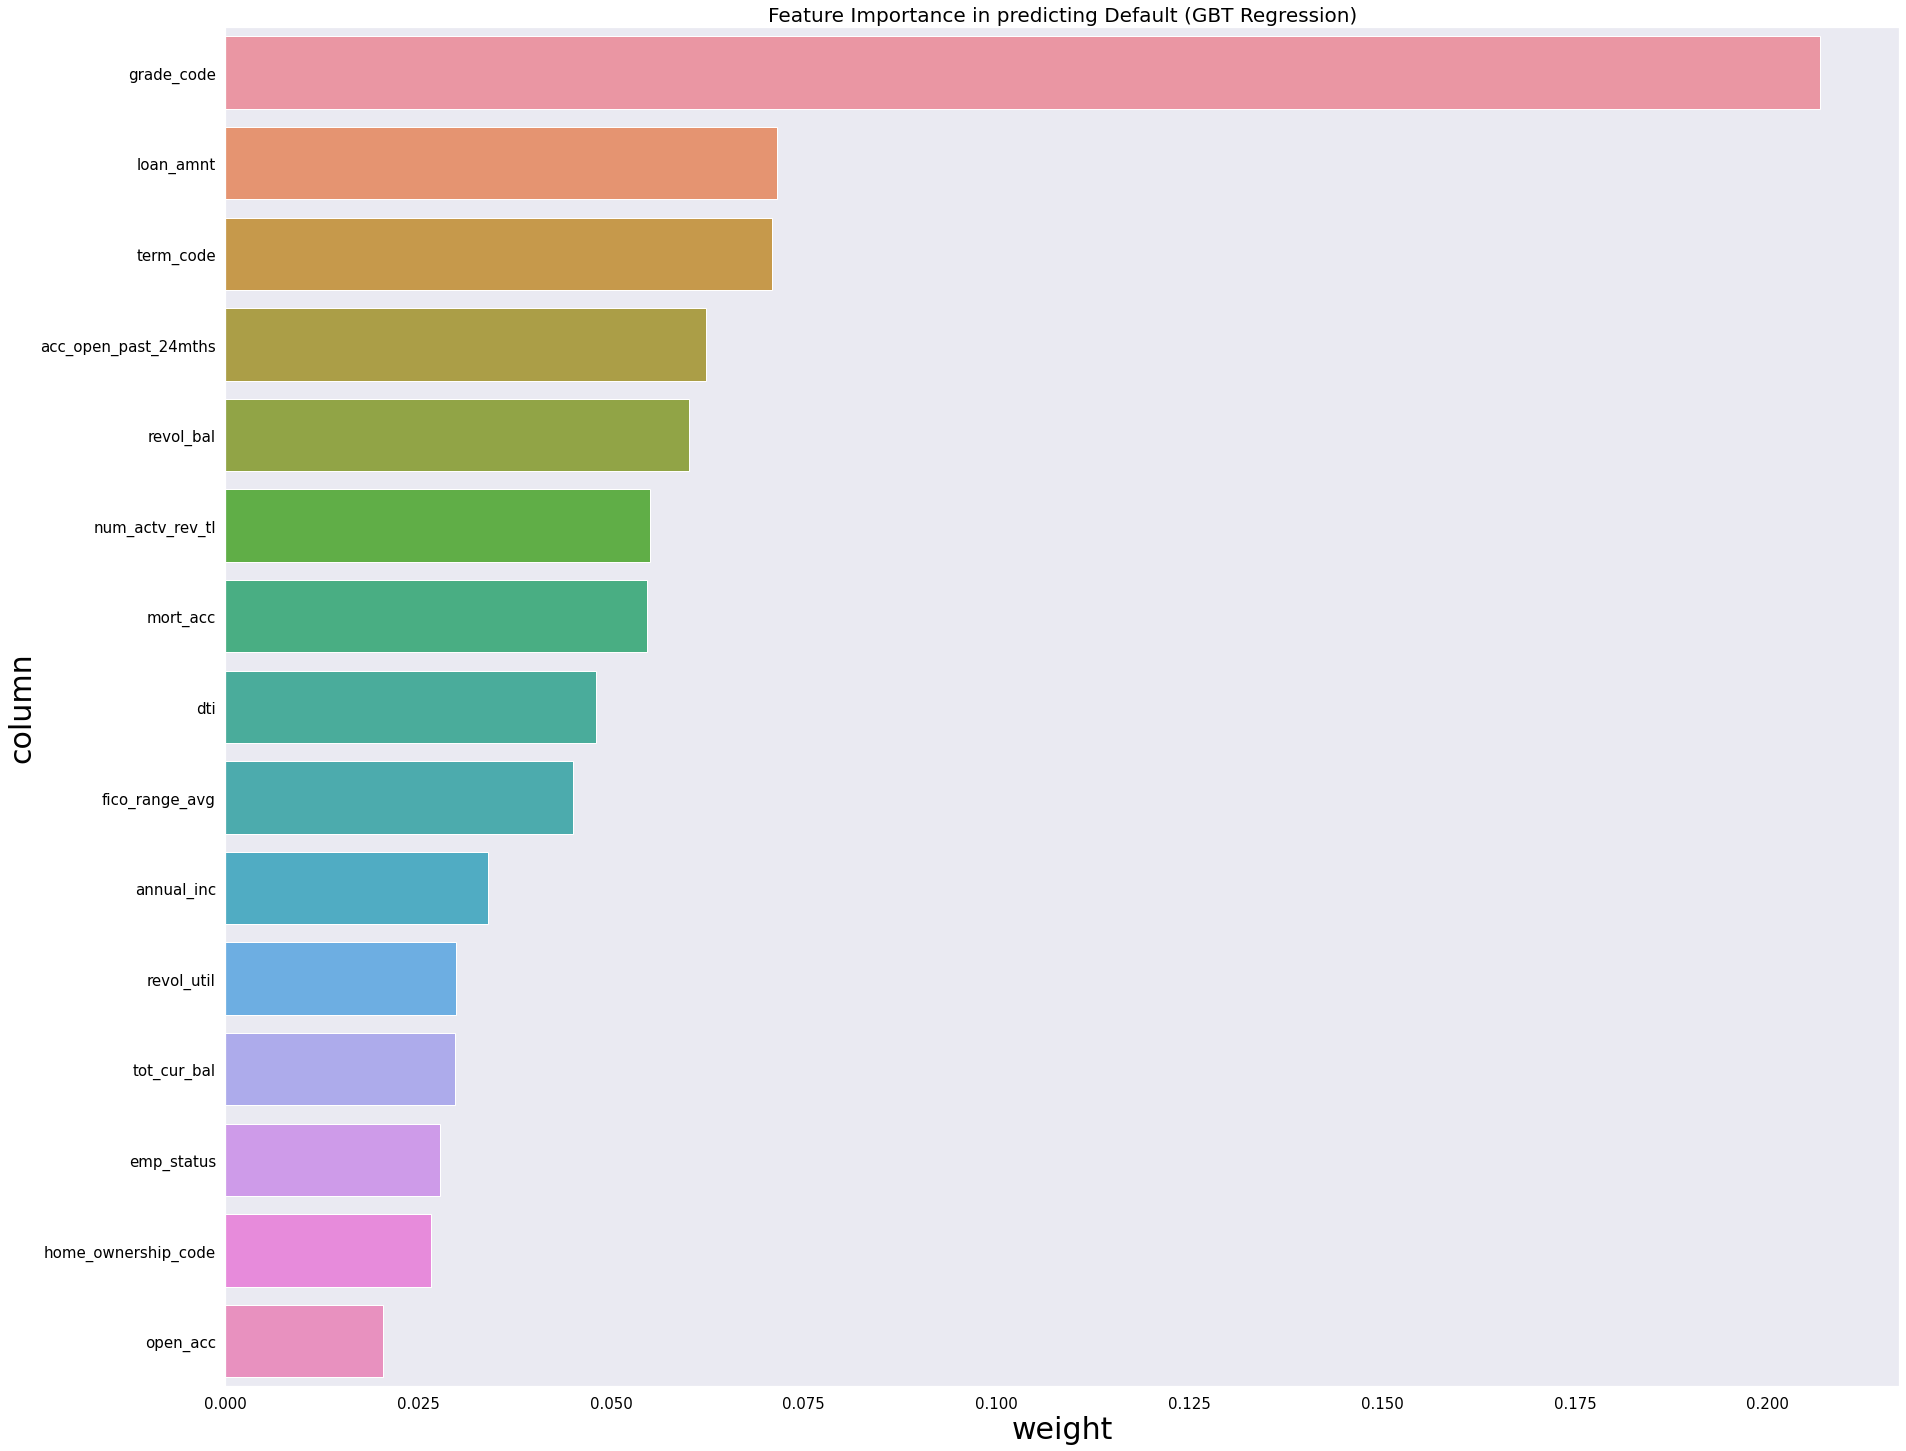

In [ ]:
gbt_plot = sns.barplot(y=gbt_feature_importance['column'][:15], x=gbt_feature_importance['weight'][:15])
plt.title("Feature Importance in predicting Default (GBT Regression)")
gbt_plot.figure.savefig("GBT_Feature.png")
plt.show()

In [ ]:
pred_train = pred_train.withColumn("prediction", F.round(pred_train["prediction"], 0))
pred_label = pred_train.selectExpr("cast(prediction as int) prediction", "isDefault")

In [ ]:
#Accuracy of GBT Model
pred_label.\
    select(F.expr('float(prediction = isDefault)').alias('correct')).\
    select(F.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.7731973608158351|
+------------------+



In [ ]:
# Create compare_1_df
import pandas as pd
compare_df = pd.DataFrame(data={"Model":["LR", "RF", "GBT"],
                                  "MSE":[lr_train_mse ,rf_train_mse,gbt_train_mse]
                                  })

compare_df.sort_values(by="MSE", ascending=True, inplace=True)

## Prediction 2: Fraction of amount a total buyer will return back

In this section we have tried to build a model to predict how much amount can an investor expect to be returned by a borrower before the term expires.



In [ ]:
if 'out_prncp' in pred2_colList:
  pred2_colList.remove('out_prncp')
toDrop_numerical = ['funded_amnt', 'total_rec_prncp', 'total_rec_int', 
                    'total_pymnt', 'total_rec_late_fee']

pred2_colList = [x for x in pred2_colList if x not in toDrop_numerical]


ValueError: ignored

In [ ]:
update_numerical = pred2_colList

In [ ]:
#pred2_colList.remove('out_prncp')
toDrop_numerical = ['funded_amnt', 'total_rec_prncp', 'total_rec_int', 
                    'total_pymnt', 'total_rec_late_fee']

pred2_colList = [x for x in pred2_colList if x not in toDrop_numerical]
update_numerical = pred2_colList

In [ ]:
trainData = training_df
testData = testing_df

### Random Forest


In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
featureIndexer =\
    VectorAssembler(inputCols=update_numerical, outputCol="indexedFeatures")

rf = RandomForestRegressor(featuresCol="indexedFeatures", labelCol='out_prncp')

if enable_grid_search:
  diamond_pipe = Pipeline(stages=[featureIndexer, rf]).fit(training_df)
  diamond_pipe_estimator = Pipeline(stages=[featureIndexer, rf])
  paramGrid = ParamGridBuilder().\
    addGrid(diamond_pipe.stages[-1].numTrees, [10, 30, 50]).\
    addGrid(diamond_pipe.stages[-1].maxDepth, [0, 1, 2, 5]).\
    addGrid(diamond_pipe.stages[-1].seed, [7]).\
    build()

  evaluator = RegressionEvaluator(
    labelCol="out_prncp", predictionCol="prediction", metricName="mse")
  crossval = CrossValidator(estimator=diamond_pipe_estimator, 
                            estimatorParamMaps=paramGrid, 
                            evaluator=evaluator, 
                            numFolds=3)
  rf_model = crossval.fit(testing_df)
  print("-----------------------------------")
  print("MSE of the crossvalidation model = %g" % min(rf_model.avgMetrics))

  best_idx = np.argmin(rf_model.avgMetrics)
  print(paramGrid[best_idx])
  pass

In [ ]:
# New Random Forest
featureIndexer =\
    VectorAssembler(inputCols=update_numerical, outputCol="indexedFeatures")


# Your code here
rf = RandomForestRegressor(featuresCol="indexedFeatures", labelCol='out_prncp', 
                           numTrees=50, maxDepth=5, seed=7)
diamond_pipe = Pipeline(stages=[featureIndexer, rf]).fit(trainData)

# Train prediction
pred_train = diamond_pipe.transform(trainData)
train_evaluater = RegressionEvaluator(labelCol='out_prncp', 
                                      predictionCol='prediction', 
                                      metricName='rmse')
train_mse = train_evaluater.evaluate(pred_train)
print("Root Mean Squared Error (RMSE) on training data = %g" % train_mse)
# Make predictions.
rf_predictions = diamond_pipe.transform(testData)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="out_prncp", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % mse)             

In [ ]:
import pandas as pd

rf_model = diamond_pipe.stages[-1]

rf_feature_importance = pd.DataFrame(list(zip(update_numerical,
                                              rf_model.featureImportances.\
                                                toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending=False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(y=rf_feature_importance['column'][:10], x=rf_feature_importance['weight'][:10])
plt.title("Feature Importance in predicting Balance Principle (Random Forest)")
plt.show()

### Gradiant Boosted Tree


In [ ]:
# Your GBT / Deep Learning grid search code here
from pyspark.ml.regression import GBTRegressor
featureIndexer =\
    VectorAssembler(inputCols=update_numerical, outputCol="indexedFeatures")

if enable_grid_search:
  gbt = GBTRegressor(featuresCol="indexedFeatures", labelCol='out_prncp')
  diamond_pipe = Pipeline(stages=[featureIndexer, gbt]).fit(trainData)
  diamond_pipe_estimator = Pipeline(stages=[featureIndexer, gbt])
  paramGrid = ParamGridBuilder().\
    addGrid(diamond_pipe.stages[-1].maxIter, [10, 100]).\
    addGrid(diamond_pipe.stages[-1].maxDepth, [0, 1, 2, 5]).\
    addGrid(diamond_pipe.stages[-1].seed, [7]).\
    build()

  evaluator = RegressionEvaluator(
    labelCol="out_prncp", predictionCol="prediction", metricName="mse")
  crossval = CrossValidator(estimator=diamond_pipe_estimator, 
                            estimatorParamMaps=paramGrid, 
                            evaluator=evaluator, 
                            numFolds=3)
  rf_model = crossval.fit(trainData)
  print("-----------------------------------")
  print("MSE of the crossvalidation model = %g" % min(rf_model.avgMetrics))

  best_idx = np.argmin(rf_model.avgMetrics)
  print(paramGrid[best_idx])
  pass

In [ ]:
gbt = GBTRegressor(featuresCol="indexedFeatures", labelCol='out_prncp', 
                   maxIter=100, maxDepth=5, seed=7)
diamond_pipe = Pipeline(stages=[featureIndexer, gbt]).fit(trainData)

# Train prediction
pred_train = diamond_pipe.transform(trainData)
train_evaluater = RegressionEvaluator(labelCol='out_prncp', 
                                      predictionCol='prediction', 
                                      metricName='rmse')
train_mse = train_evaluater.evaluate(pred_train)
print("Root Mean Squared Error (RMSE) on training data = %g" % train_mse)
# Make predictions.
gbt_predictions = diamond_pipe.transform(testData)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="out_prncp", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % mse)    

In [ ]:
import pandas as pd

gbt_model = diamond_pipe.stages[-1]

gbt_feature_importance = pd.DataFrame(list(zip(update_numerical,
                                              gbt_model.featureImportances.\
                                                toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending=False)

In [ ]:
sns.barplot(y=gbt_feature_importance['column'][:10], x=gbt_feature_importance['weight'][:10])
plt.title("Feature Importance in predicting Balance Principle (GBT)")
plt.show()

### Linear Regression

In [ ]:
from pyspark.ml import feature
from pyspark.ml.regression import LinearRegression
inference_pipe = Pipeline(stages=[featureIndexer,
                                  feature.StandardScaler(inputCol='indexedFeatures', 
                                                         outputCol='scaledFeatures'),
                                  LinearRegression(labelCol='out_prncp', 
                                                   featuresCol='indexedFeatures')]).fit(trainData)

predictions = inference_pipe.transform(trainData)
evaluator = RegressionEvaluator(
    labelCol="out_prncp", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)  
evaluator = RegressionEvaluator(
    labelCol="out_prncp", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % mse)                                                     


In [ ]:
lr_model = inference_pipe.stages[-1]

lr_feature_importance = pd.DataFrame(list(zip(update_numerical,
                                              abs(lr_model.coefficients.toArray()))),
            columns = ['column', 'weight']).sort_values('weight', ascending=False)

In [ ]:
sns.barplot(y=lr_feature_importance['column'][:10], x=lr_feature_importance['weight'][:10])
plt.title("Feature Importance in predicting Balance Principle (Linear Regression)")
plt.show()

In [ ]:
predictions_pd = predictions.toPandas()

In [ ]:
sns.scatterplot(y=predictions_pd['prediction'], x=predictions_pd['out_prncp'])
plt.title("Linear Regression")
plt.show()

In [ ]:
rf_predictions_pd = rf_predictions.toPandas()

In [ ]:
sns.scatterplot(y=rf_predictions_pd['prediction'], x=rf_predictions_pd['out_prncp'])
plt.title("Random Forest")
plt.show()

## Prediction 3: Return on Invetment 

In this section we have build different models to compute the return on investment for the investor which will help the investor to find a profitable loan request.

In [ ]:
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator



### Linear Regression

In [ ]:
### Linear Regression
va2= feature.VectorAssembler(inputCols=['funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range_low', 'open_acc', 'total_acc', 'tot_cur_bal', 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'disbursement_method'], outputCol='features')

d_pipe=regression.LinearRegression(featuresCol='features',labelCol='return_inv')
sc = feature.StandardScaler(withMean=True, inputCol='features')

model2 = Pipeline(stages=[va2,sc, d_pipe])
model2_fitted = model2.fit(training_df)



In [ ]:
coefficients_df=model2_fitted.stages[2].coefficients
coeff=['funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range_low', 'open_acc', 'total_acc', 'tot_cur_bal', 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'disbursement_method']
coefficients_df = pd.DataFrame(data={'coefficient':coeff,'value':model2_fitted.stages[2].coefficients})
pd.options.display.float_format = '{:.5f}'.format
a=coefficients_df['value']
coefficients_df_2 = pd.DataFrame(data={'coefficient':coeff,'Values':a})

display(coefficients_df_2)
coefficients_df_2.dtypes

In [ ]:
mse = F.mean((F.col('total_pymnt_inv') - F.col('prediction'))**2).alias('mse')
print("Model2 train mse:")
model2_fitted.transform(training_df).select(mse).show()

print("Model2 test mse:")
model2_fitted.transform(testing_df).select(mse).show()



```
# This is formatted as code
```

### Random Forest

In the following section we have built a Random Forest regressor model

In [ ]:
### Random Forest Regression




from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator


# Train a RandomForest model.

va= feature.VectorAssembler(inputCols=['funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range_low', 'open_acc', 'total_acc', 'tot_cur_bal', 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'disbursement_method'], outputCol='features')

rf_best = RandomForestRegressor(numTrees=5, maxDepth=3).setLabelCol("total_pymnt_inv")

best_pipe  = Pipeline(stages=[va, rf_best]).fit(training_df)


In [ ]:
rf_model = best_pipe.stages[-1]
rf_feature_importance=pd.DataFrame(list(zip(coeff, rf_model.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight')
display(rf_feature_importance)

In [ ]:
#from pyspark.sql import functions as fn

mse = F.mean((F.col('total_pymnt_inv') - F.col('prediction'))**2).alias('mse')

print("Best Model train mse:")
best_pipe.transform(training_df).select(mse).show()

print("Best Model test mse:")
best_pipe.transform(testing_df).select(mse).show()

In [ ]:
print(rf_model.trees[1].toDebugString)